#  Набор данных о временных рядов акций DJIA 30

## О наборе данных

##### Содержание

Данные фондового рынка могут быть интересны для анализа, и в качестве дополнительного стимула надежные прогностические модели могут принести большую финансовую отдачу. Количество финансовых данных в Интернете, по-видимому, бесконечно. Получить большой и хорошо структурированный набор данных по широкому кругу компаний может быть непросто. Здесь представлен набор данных с историческими ценами акций (за последние 12 лет) для 29 из 30 компаний DJIA (исключая 'V', поскольку в нем нет полных данных за 12 лет).а
Здесь указаны 5 параметров:-мм-дд
- `open` - цена акций в момент открытия рынка
- `high` - самая высокая цена акций, достигнутая в день
- `low` - самая низкая цена акций, достигнутая в день
- `close` - цена акций в момент закрытия рынка
- `volume` - количество проданных акциймпании

Ссылка kaggle: https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?select=GOOGL_2006-01-01_to_2018-01-01.csv

Целевой признак будет - средняя цена акций в момент открытия и закрытия, в котором будет добавлена в таблицу (average_price) рынка

## Подготовка

### Подключение библиотеки

In [1]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Для визуализации временных рядов
import plotly.graph_objects
import seaborn as sb
from scipy import stats as st
# Время обучения модели
import timeit
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson
# XGBRegressor
import xgboost as xgb

from lightgbm import LGBMRegressor
# Вызов библиотеки для отключения предупреждения
import warnings

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit
# Применим кроссвалидацию для повышения качеств обучения
# Для константной модели
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# и для машинного обучения разными способами (по условию мы выбираем линейную регрессию):
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve,
    # MSE
    mean_squared_error,
    mean_absolute_error,
    fbeta_score, 
    make_scorer
)

# Контроль выборки
from sklearn.utils import shuffle

### Загрузим данные

In [2]:
# Получаем датасет
try:
    # Сразу устанавливаем время как индексы
    df_train = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', index_col=[0], parse_dates=[0])
    df_test = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', index_col=[0], parse_dates=[0])
except Exception as error:
    print('Отсутствует датасет. Проверьте путь файла')
    print('ERROR:', error)

### Изучим данные

#### Обучающий датасет

In [3]:
display(df_train.info())
display(df_train.describe())
display(df_train.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3019 non-null   float64
 1   high    3019 non-null   float64
 2   low     3019 non-null   float64
 3   close   3019 non-null   float64
 4   volume  3019 non-null   int64  
 5   name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


None

,open,high,low,close,volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,428.200802,431.835618,424.130275,428.044001,3.551504e+06
std,236.320026,237.514087,234.923747,236.343238,3.038599e+06
min,131.390000,134.820000,123.770000,128.850000,5.211410e+05
25%,247.775000,250.190000,244.035000,247.605000,1.760854e+06
50%,310.480000,312.810000,307.790000,310.080000,2.517630e+06
75%,572.140000,575.975000,565.900000,570.770000,4.242182e+06
max,1083.020000,1086.490000,1072.270000,1085.090000,4.118289e+07


,open,high,low,close,volume,name
date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


#### Тестируемый датасет

In [4]:
display(df_test.info())
display(df_test.describe())
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3019 non-null   float64
 1   high    3019 non-null   float64
 2   low     3019 non-null   float64
 3   close   3019 non-null   float64
 4   volume  3019 non-null   int64  
 5   name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


None

,open,high,low,close,volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,428.200802,431.835618,424.130275,428.044001,3.551504e+06
std,236.320026,237.514087,234.923747,236.343238,3.038599e+06
min,131.390000,134.820000,123.770000,128.850000,5.211410e+05
25%,247.775000,250.190000,244.035000,247.605000,1.760854e+06
50%,310.480000,312.810000,307.790000,310.080000,2.517630e+06
75%,572.140000,575.975000,565.900000,570.770000,4.242182e+06
max,1083.020000,1086.490000,1072.270000,1085.090000,4.118289e+07


,open,high,low,close,volume,name
date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


## Предобработка данных

### Пропуски

In [5]:
df_train.isna().sum()

open      0
high      0
low       0
close     0
volume    0
name      0
dtype: int64

In [6]:
df_test.isna().sum()

open      0
high      0
low       0
close     0
volume    0
name      0
dtype: int64

### Дублирующие значения

In [7]:
df_train.duplicated().sum()

0

In [8]:
df_test.duplicated().sum()

0

У нас есть значение в столбце name, мы его удалим, т.к. чтобы не было конфликта в обучающей и тестовой выборке.

In [9]:
# Для df_train
df_train.drop(columns=['name'], inplace=True)
# Для df_test
df_test.drop(columns=['name'], inplace=True)

Добавим среднее значения цен в конец столбца, для дальнейшего анализа данных.

In [10]:
# Добавляем новый столбец 'average_price' средняя цена в момент открытия и закрытия акции
# Для df_train
df_train['average_price'] = (df_train['open'] + df_train['close']) / 2

# Для df_test
df_test['average_price'] = (df_test['open'] + df_test['close']) / 2

In [11]:
# Проверим
display(df_train.head())
display(df_test.head())

,open,high,low,close,volume,average_price
date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,214.650
2006-01-04,222.17,224.70,220.09,222.84,15292353,222.505
2006-01-05,223.22,226.00,220.97,225.85,10815661,224.535
2006-01-06,228.66,235.49,226.85,233.06,17759521,230.860
2006-01-09,233.44,236.94,230.70,233.68,12795837,233.560


,open,high,low,close,volume,average_price
date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,214.650
2006-01-04,222.17,224.70,220.09,222.84,15292353,222.505
2006-01-05,223.22,226.00,220.97,225.85,10815661,224.535
2006-01-06,228.66,235.49,226.85,233.06,17759521,230.860
2006-01-09,233.44,236.94,230.70,233.68,12795837,233.560


## Анализ

### Первый график временного ряда.  Цена акции на момент открытия рынка

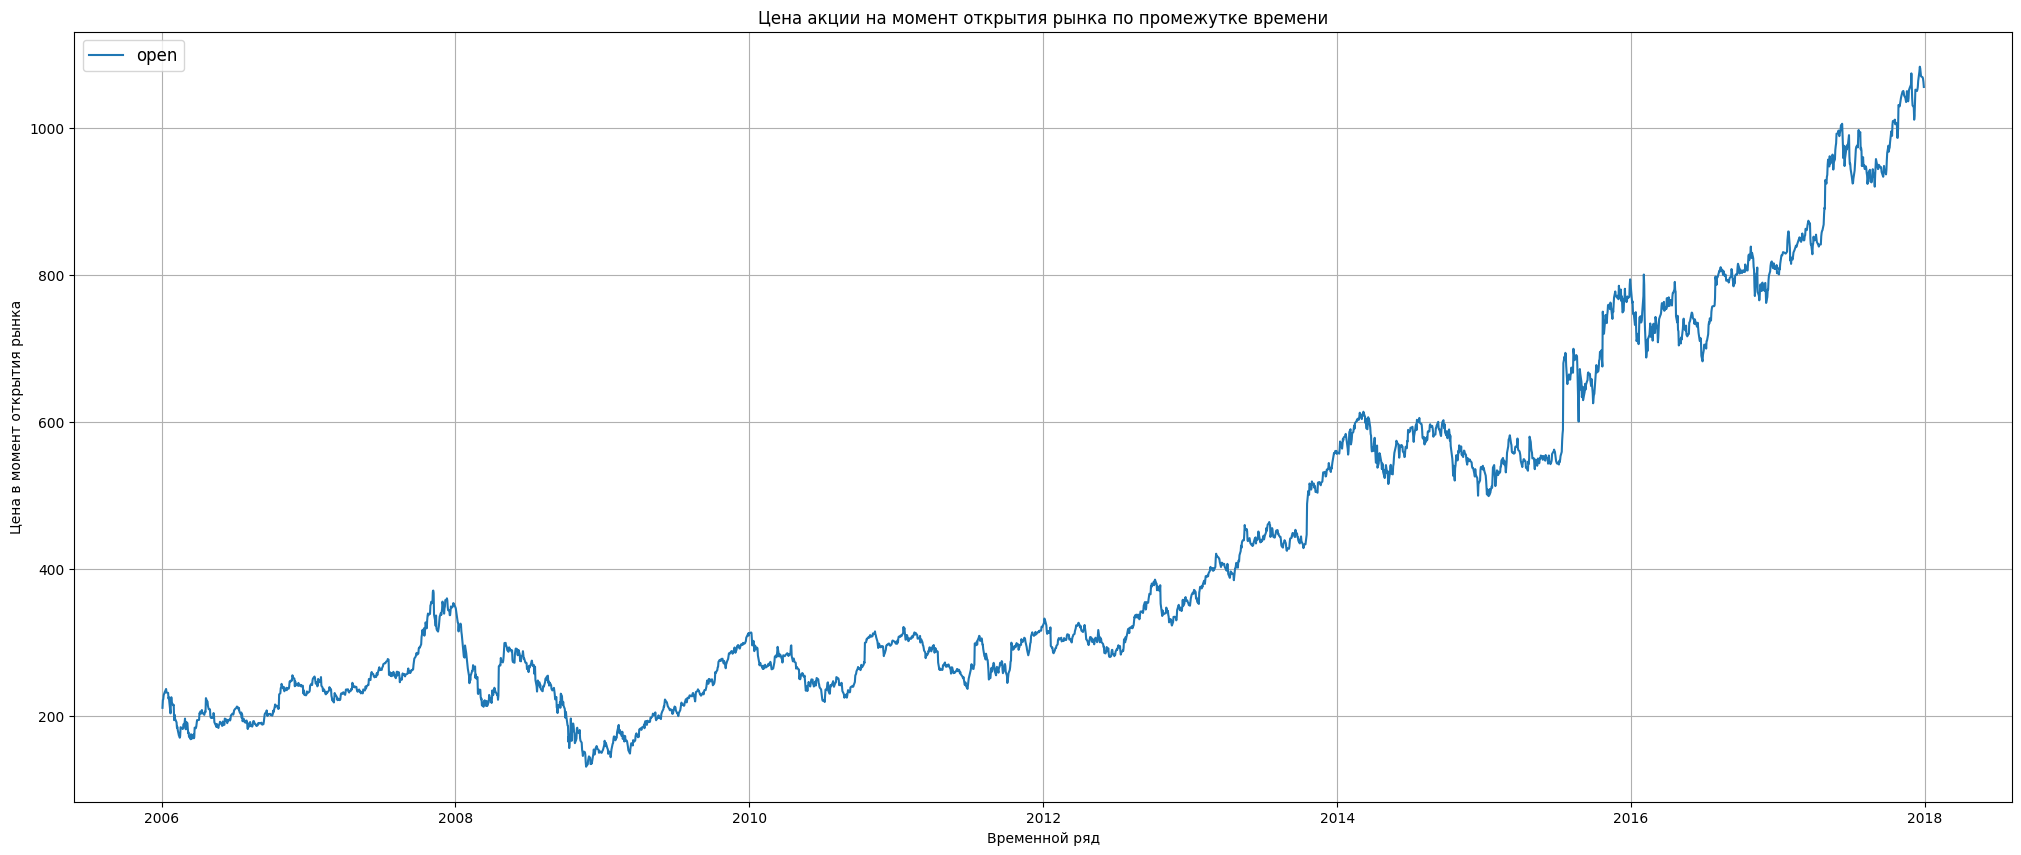

In [12]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['open'])
ax_year.grid()

plt.title('Цена акции на момент открытия рынка по промежутке времени')
ax_year.set_xlabel('Временной ряд')
ax_year.set_ylabel('Цена в момент открытия рынка')
ax_year.legend(['open'], fontsize='larger')

plt.show()

Цена акции на момент открытия увеличивается с каждым годом

#### Самая высокая цена, достигнутая за день

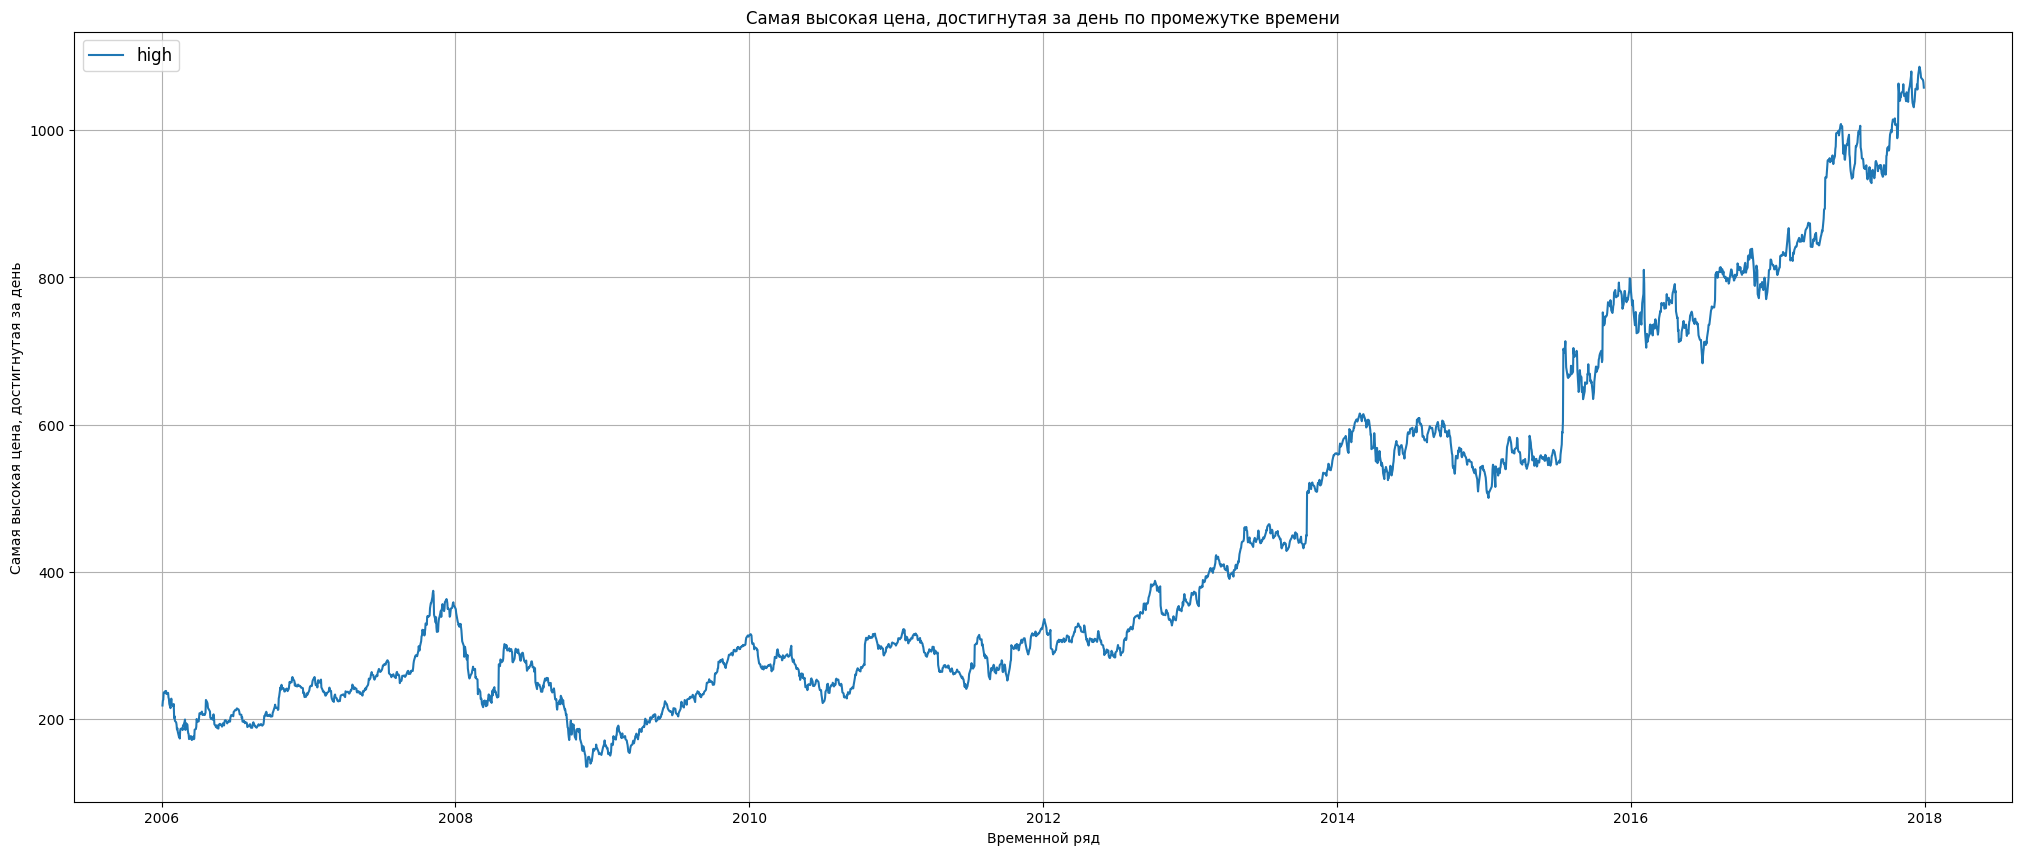

In [13]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['high'])
ax_year.grid()

plt.title('Самая высокая цена, достигнутая за день по промежутке времени')
ax_year.set_xlabel('Временной ряд')
ax_year.set_ylabel('Самая высокая цена, достигнутая за день')
ax_year.legend(['high'], fontsize='larger')

plt.show()

Самая высокая цена акций, достигнутая в день, увеличивается с каждым годом

#### самая низкая цена, достигнутая за день

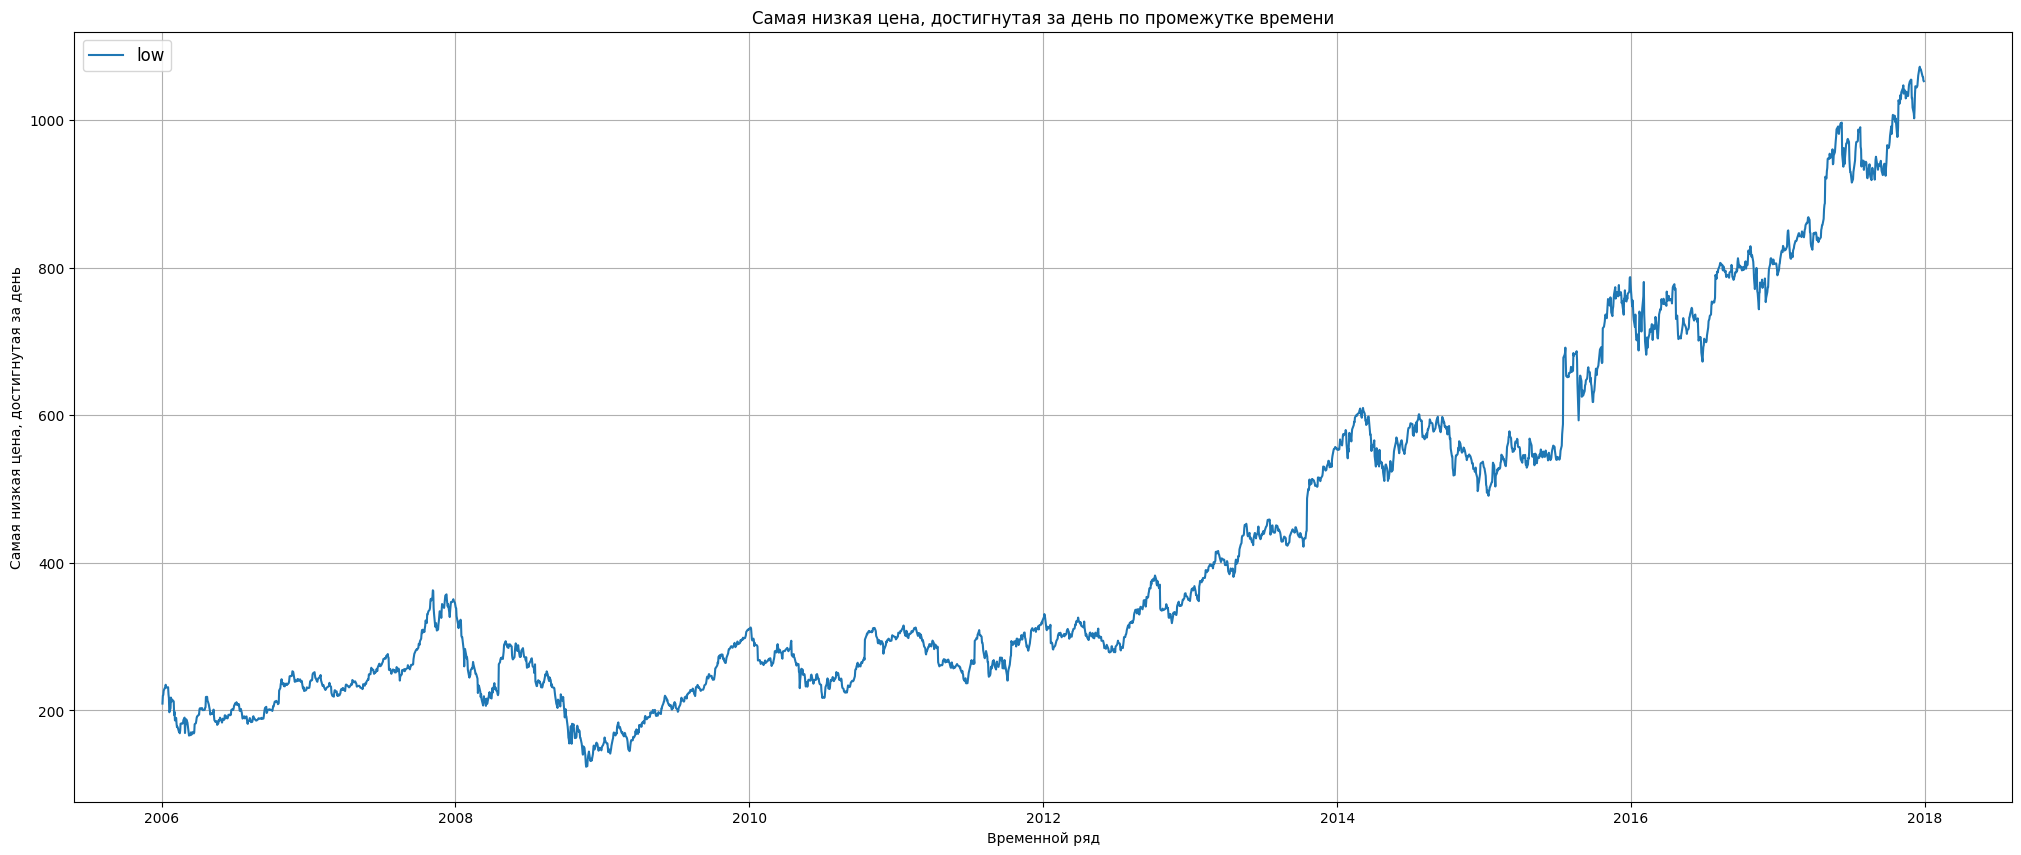

In [14]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['low'])
ax_year.grid()

plt.title('Cамая низкая цена, достигнутая за день по промежутке времени')
ax_year.set_xlabel('Временной ряд')
ax_year.set_ylabel('Cамая низкая цена, достигнутая за день')
ax_year.legend(['low'], fontsize='larger')

plt.show()

Самая низкая цена акций, достигнутая в день, увеличивается с каждым годом

### Цена акции на момент закрытия

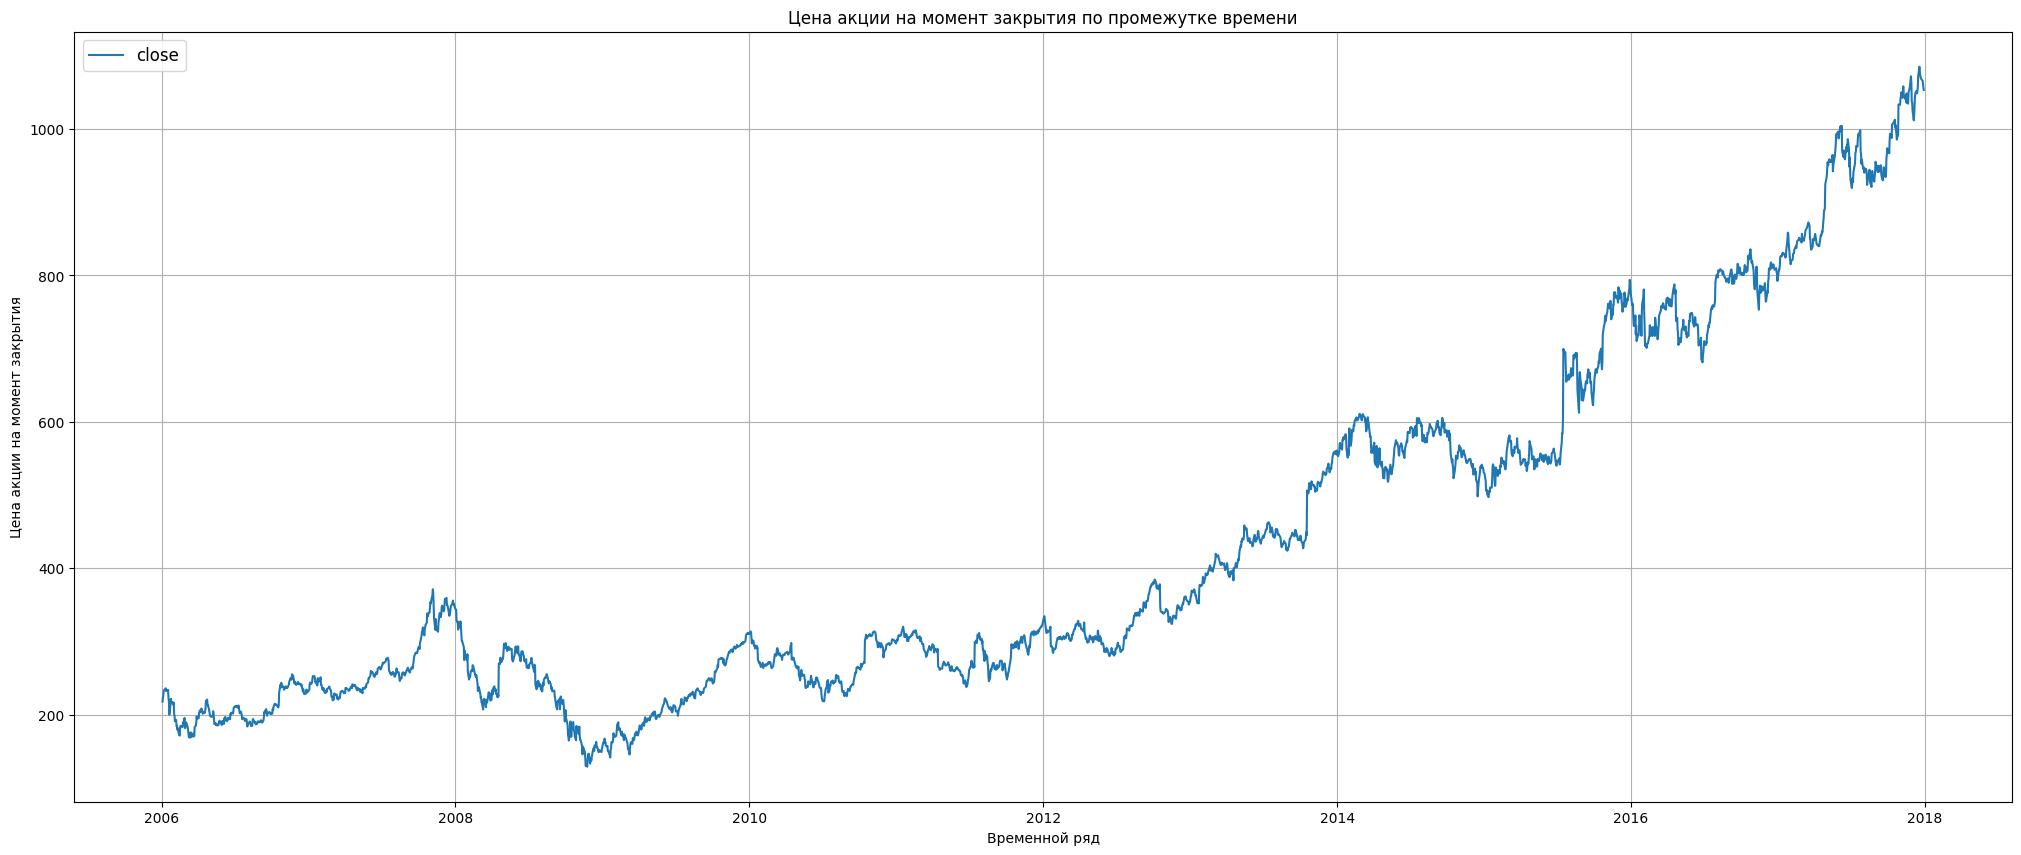

In [15]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['close'])
ax_year.grid()

plt.title('Цена акции на момент закрытия по промежутке времени')
ax_year.set_xlabel('Временной ряд')
ax_year.set_ylabel('Цена акции на момент закрытия')
ax_year.legend(['close'], fontsize='larger')

plt.show()

Цена акций на момент закрытия рынка увеличивается с каждым годом

#### Количество проданных акций

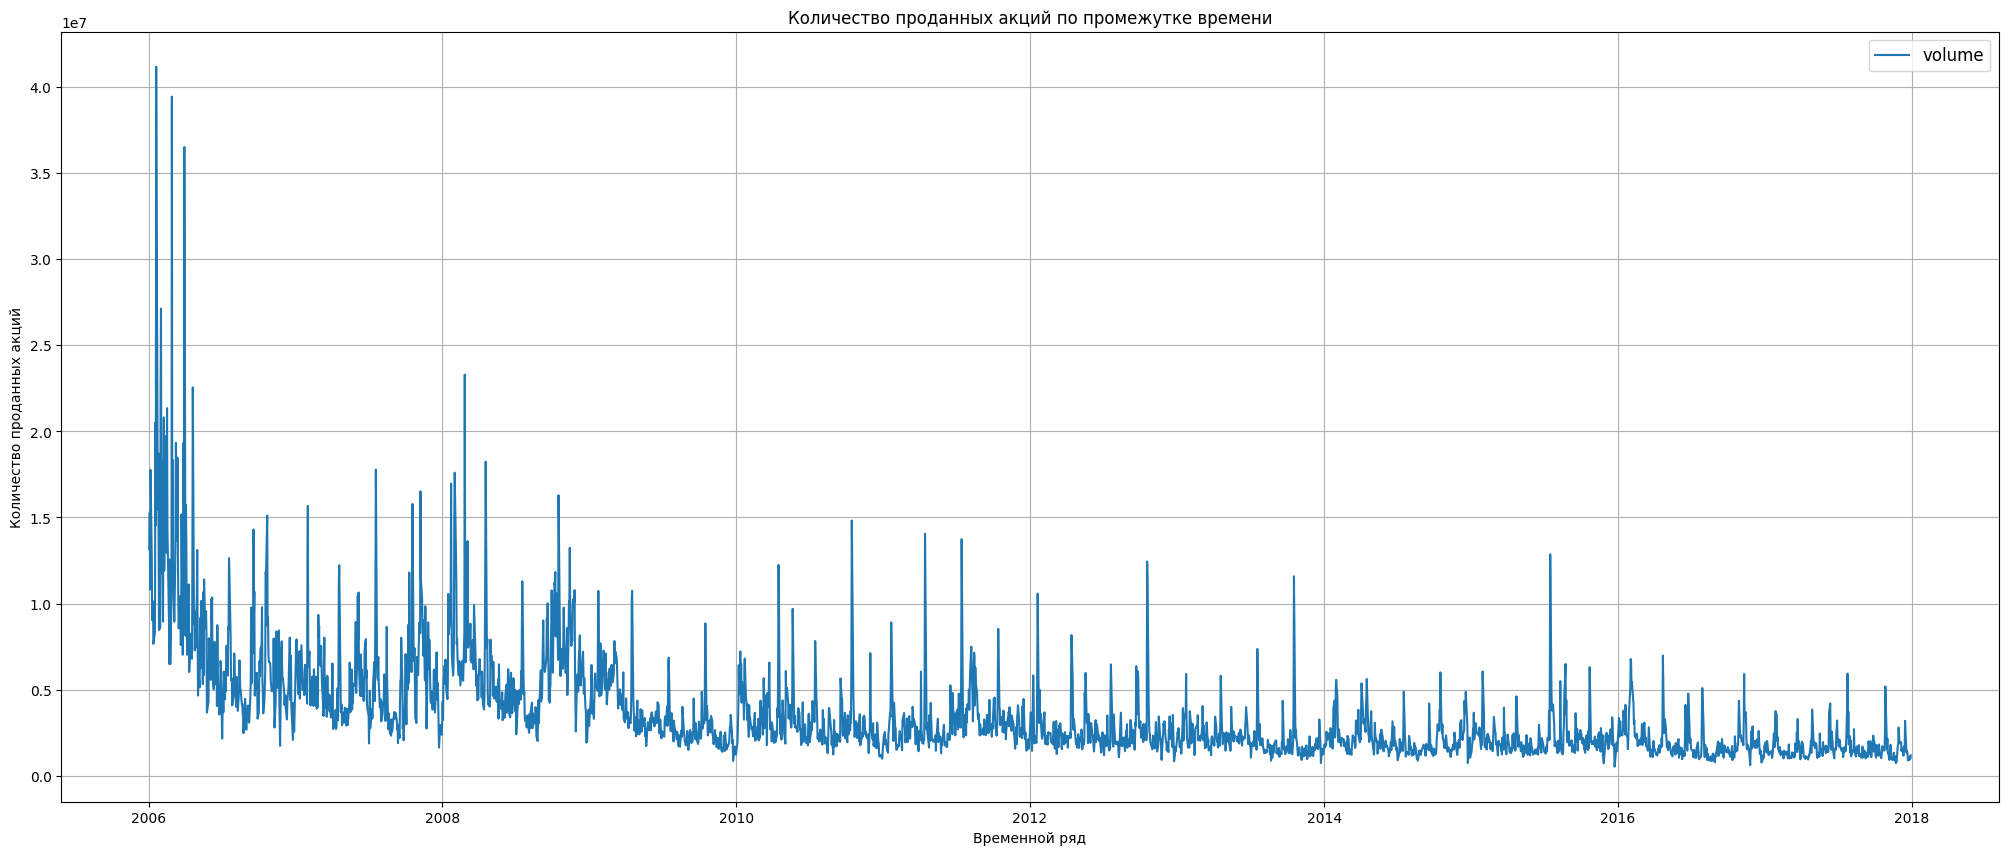

In [16]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['volume'])
ax_year.grid()

plt.title('Количество проданных акций по промежутке времени')
ax_year.set_xlabel('Временной ряд')
ax_year.set_ylabel('Количество проданных акций')
ax_year.legend(['volume'], fontsize='larger')

plt.show()

Количество проданных акций уменьшается с каждым годом

### Средняя цена акции на момент открытия и закрытия акций

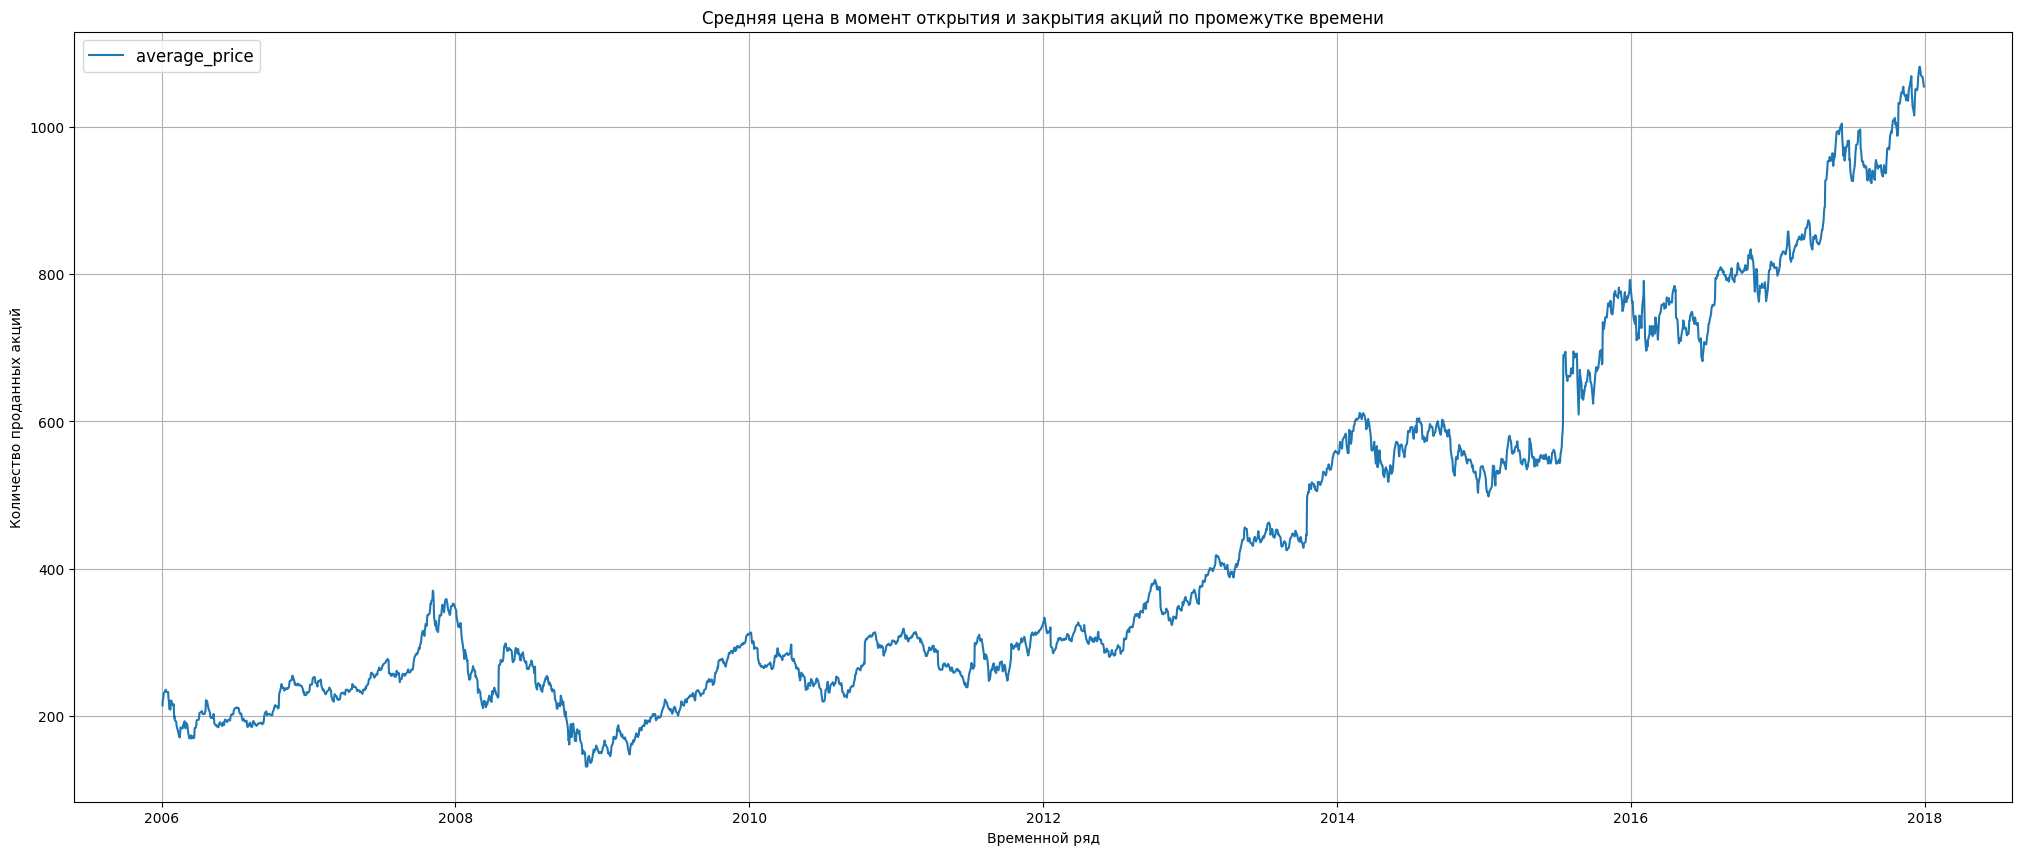

In [17]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['average_price'])
ax_year.grid()

plt.title('Средняя цена в момент открытия и закрытия акций по промежутке времени')
ax_year.set_xlabel('Временной ряд')
ax_year.set_ylabel('Количество проданных акций')
ax_year.legend(['average_price'], fontsize='larger')

plt.show()

Средняя цена акций в момент открытия и закрытия рынка увеличивается с каждым годом

### График со скользящими средними

In [18]:
df_train_temp = df_train[['average_price']]
df_test_temp = df_test[['average_price']]

In [19]:
# Добавим скользящие среднее
df_train_temp['rolling_average_price'] = df_train_temp.rolling(10).mean()
df_test_temp['rolling_average_price'] = df_test_temp.rolling(10).mean()

C:\Users\nikis\AppData\Local\Temp\ipykernel_8040\2175444835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_temp['rolling_average_price'] = df_train_temp.rolling(10).mean()
C:\Users\nikis\AppData\Local\Temp\ipykernel_8040\2175444835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_temp['rolling_average_price'] = df_test_temp.rolling(10).mean()


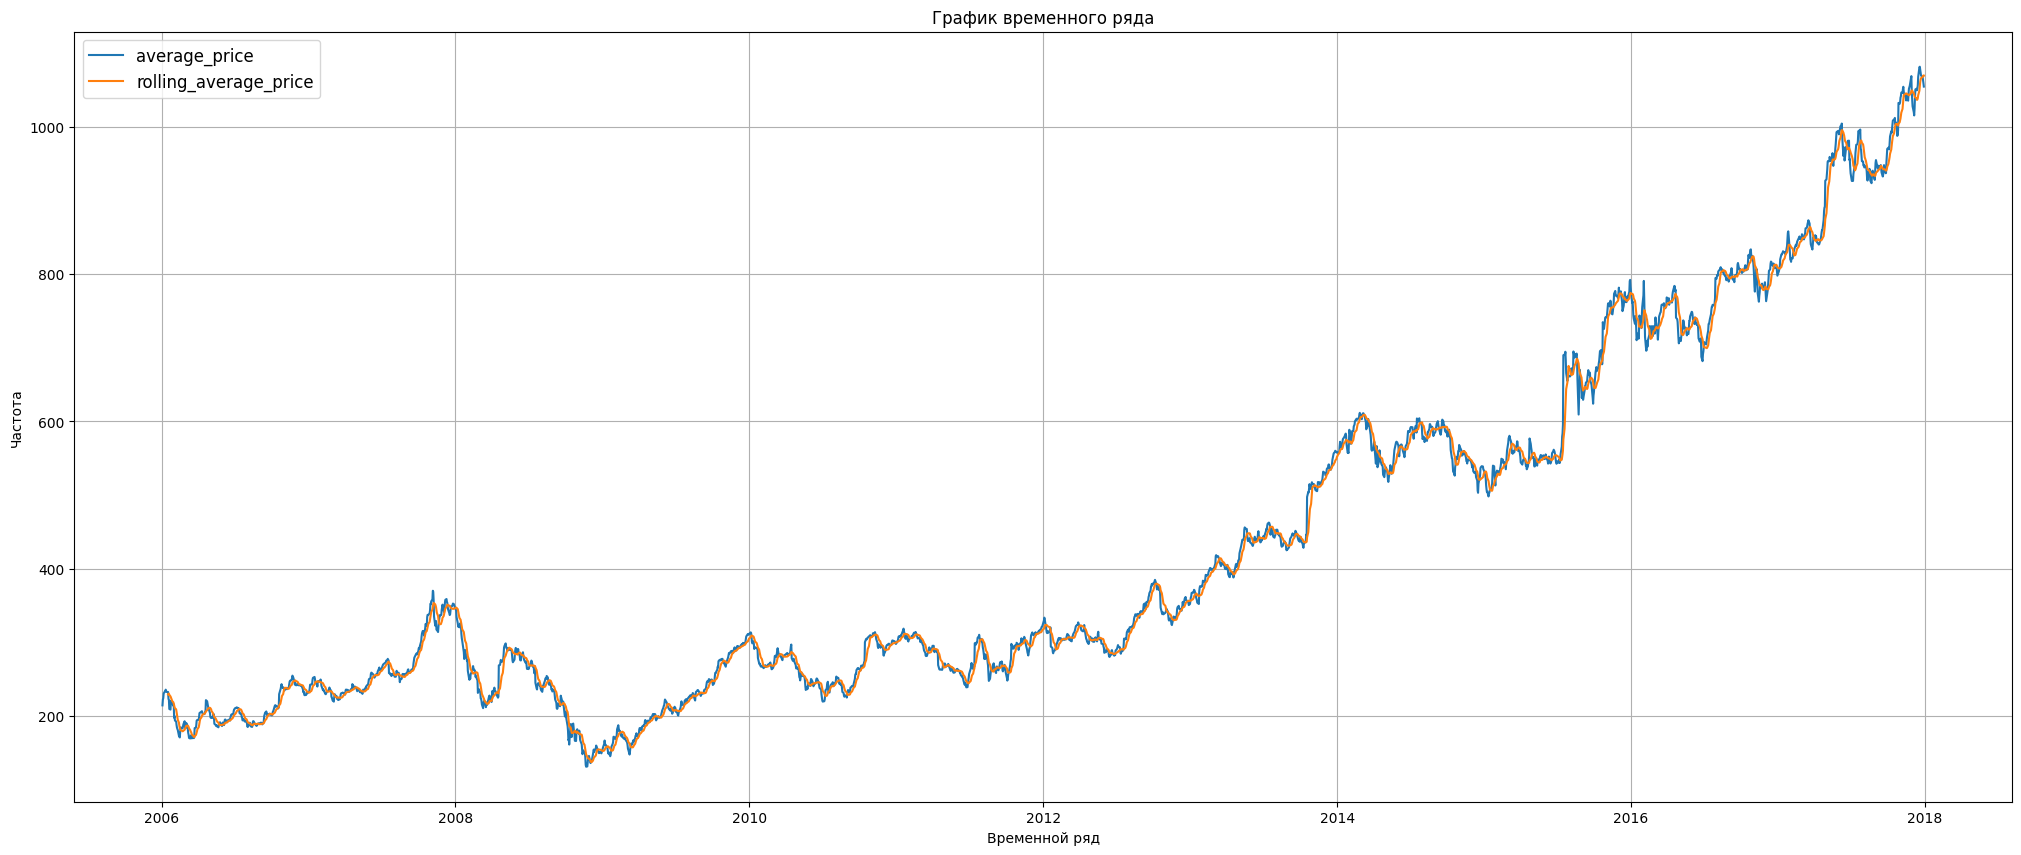

In [20]:
# И снова рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train_temp.index, df_train_temp)
ax_year.grid()

plt.title('График временного ряда')
ax_year.set_xlabel('Временной ряд')
ax_year.set_ylabel('Частота')
ax_year.legend(df_train_temp, fontsize='larger')

plt.show()

Здесь получилось неудобной и неинформативной, рассмотрим определенный промежуток времени

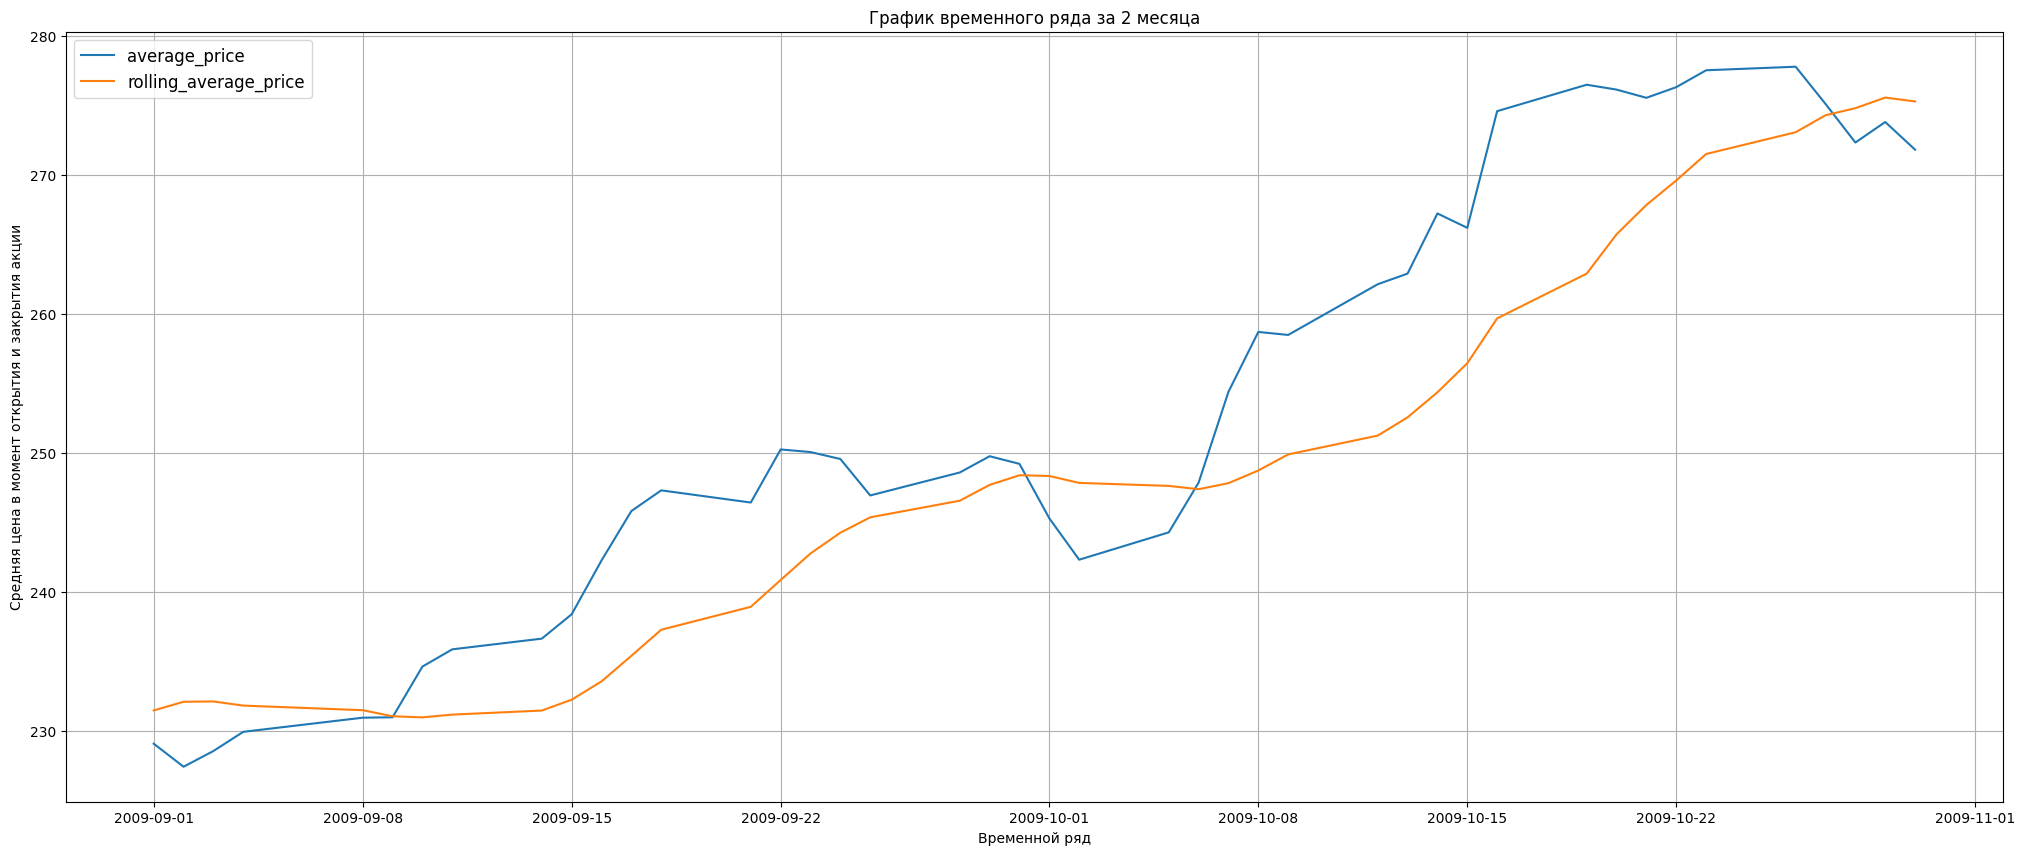

In [21]:
fig, ax_month = plt.subplots(figsize=(25,10))

# За 2 месяца
ax_month.plot(df_train_temp['2009-09-01':'2009-11-01'].index, df_train_temp['2009-09-01':'2009-11-01'])
ax_month.grid()

plt.title('График временного ряда за 2 месяца')
ax_month.set_xlabel('Временной ряд')
ax_month.set_ylabel('Средняя цена в момент открытия и закрытия акции')
ax_month.legend(df_train_temp, fontsize='larger')

plt.show()

Рост средней цены акции за осень 2009 года

### Исследуем стационарные ряды

In [22]:
df_train_temp['std'] = df_train_temp['average_price'].rolling(15).std()
df_test_temp['std'] = df_test_temp['average_price'].rolling(15).std()

C:\Users\nikis\AppData\Local\Temp\ipykernel_8040\667429206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_temp['std'] = df_train_temp['average_price'].rolling(15).std()
C:\Users\nikis\AppData\Local\Temp\ipykernel_8040\667429206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_temp['std'] = df_test_temp['average_price'].rolling(15).std()


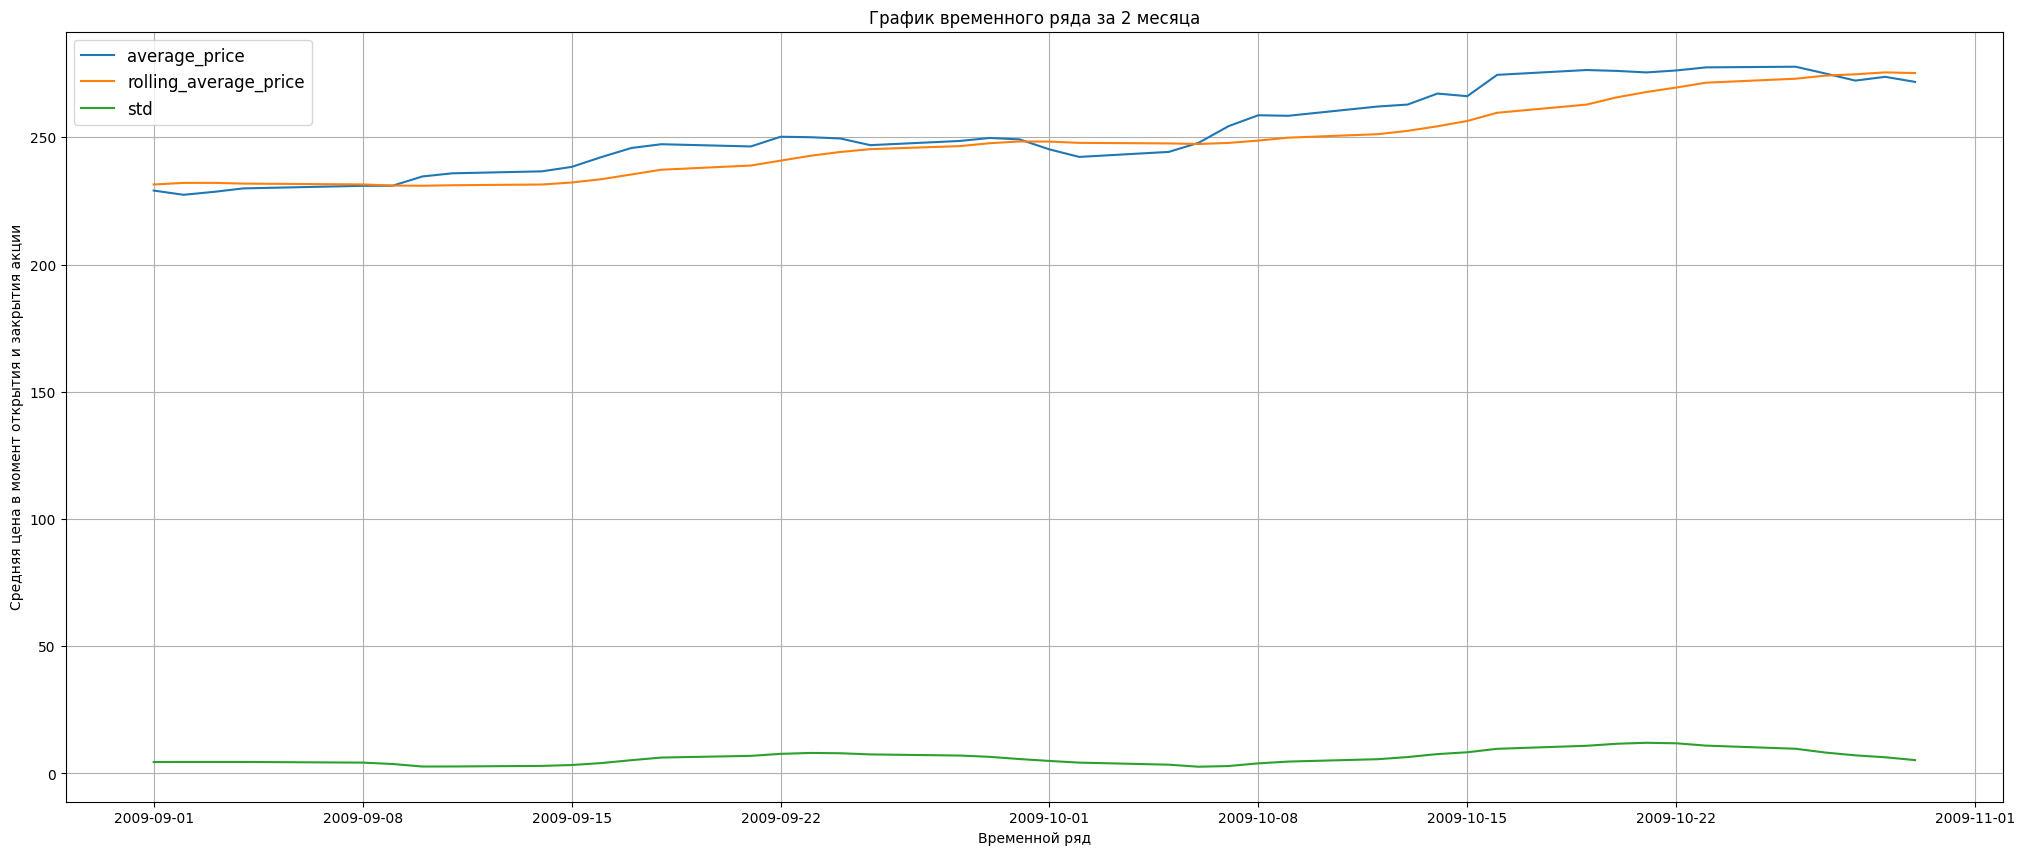

In [23]:
# И снова рассмотрим график и узнаем о нем
fig, ax_month = plt.subplots(figsize=(25,10))

# За 2 месяца
ax_month.plot(df_train_temp['2009-09-01':'2009-11-01'].index, df_train_temp['2009-09-01':'2009-11-01'])
ax_month.grid()

plt.title('График временного ряда за 2 месяца')
ax_month.set_xlabel('Временной ряд')
ax_month.set_ylabel('Средняя цена в момент открытия и закрытия акции')
ax_month.legend(df_train_temp, fontsize='larger')

plt.show()

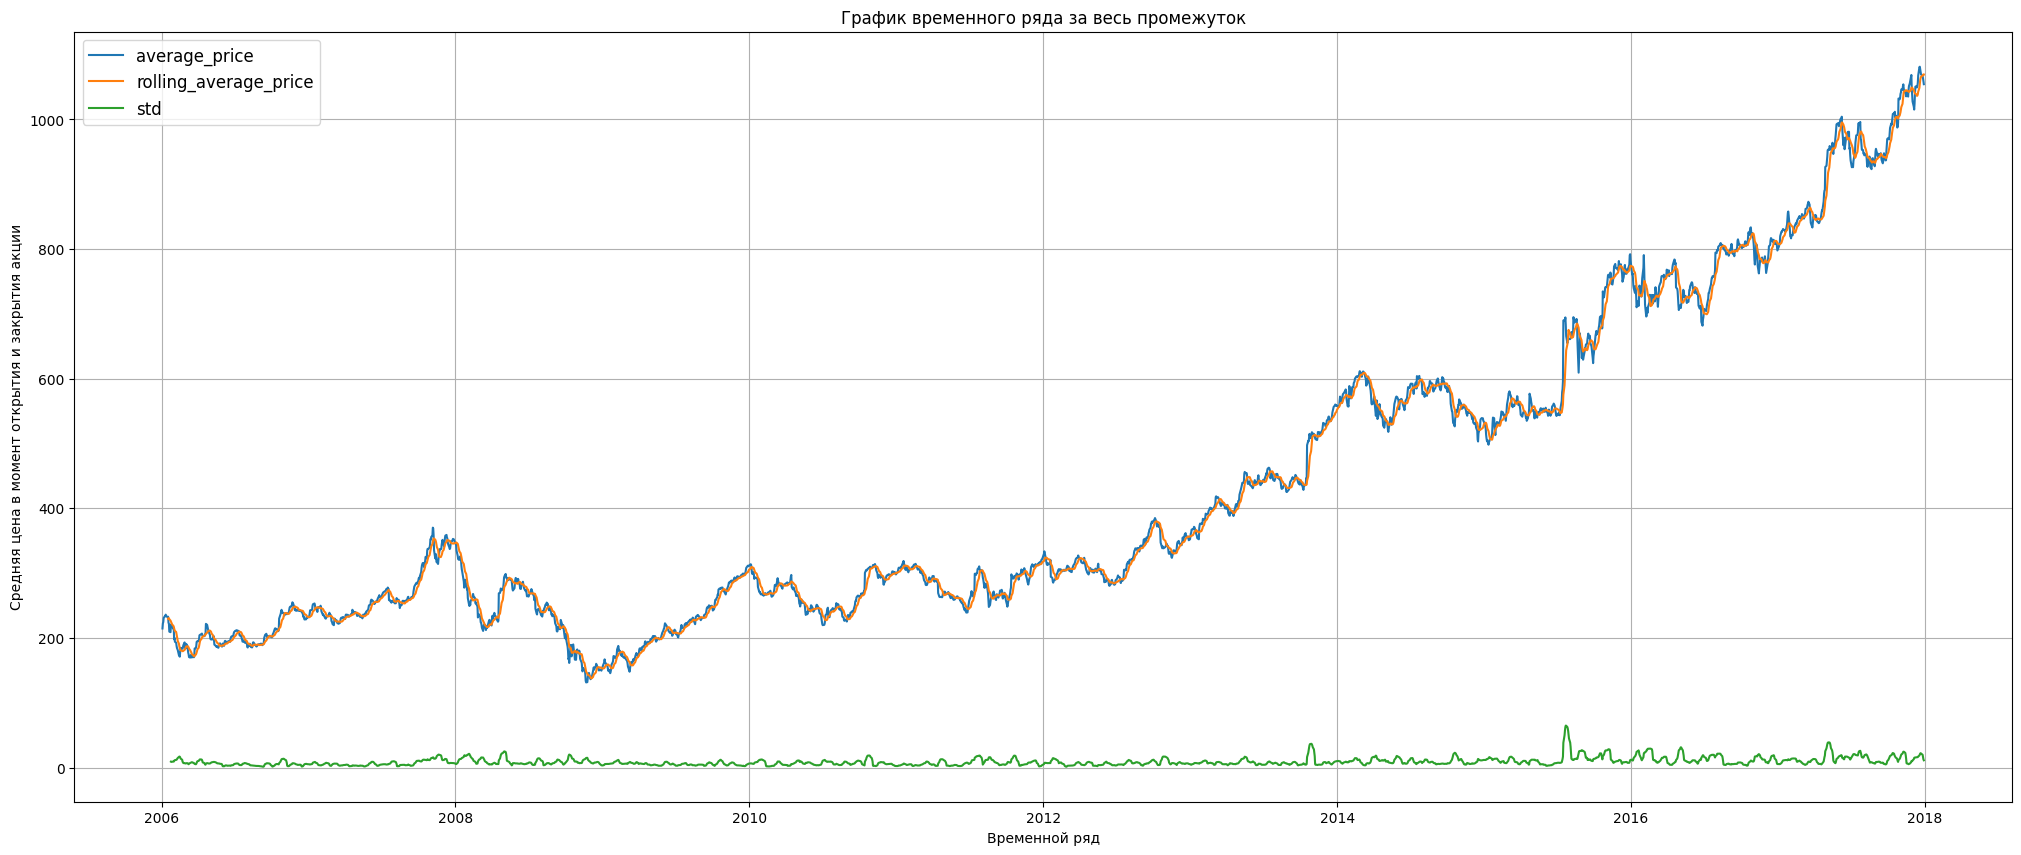

In [24]:
# И снова рассмотрим график и узнаем о нем
fig, ax_month = plt.subplots(figsize=(25,10))

# За месяца
ax_month.plot(df_train_temp.index, df_train_temp)
ax_month.grid()

plt.title('График временного ряда за весь промежуток')
ax_month.set_xlabel('Временной ряд')
ax_month.set_ylabel('Средняя цена в момент открытия и закрытия акции')
ax_month.legend(df_train_temp, fontsize='larger')

plt.show()

Примечание:

Стохастический процесс - это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются
Стохастический процесс стационарный (англ. stationary stochastic process), если его распределение со временем не меняется. Например, к такому процессу относятся периодические колебания значений

Если распределение меняется, то процесс называется нестационарным

Насчет временного ряда, его можно назвать стационарным или нет - нельзя, пока не проверим на тренды, сезонность и остаток декомпозиции

### Тренды и сезонность

In [25]:
df_train_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   average_price          3019 non-null   float64
 1   rolling_average_price  3010 non-null   float64
 2   std                    3005 non-null   float64
dtypes: float64(3)
memory usage: 158.9 KB


#### Тренд

In [26]:
# если период сезонности составляет 12 месяцев
decomposed = seasonal_decompose(df_train_temp['average_price'], period=12)

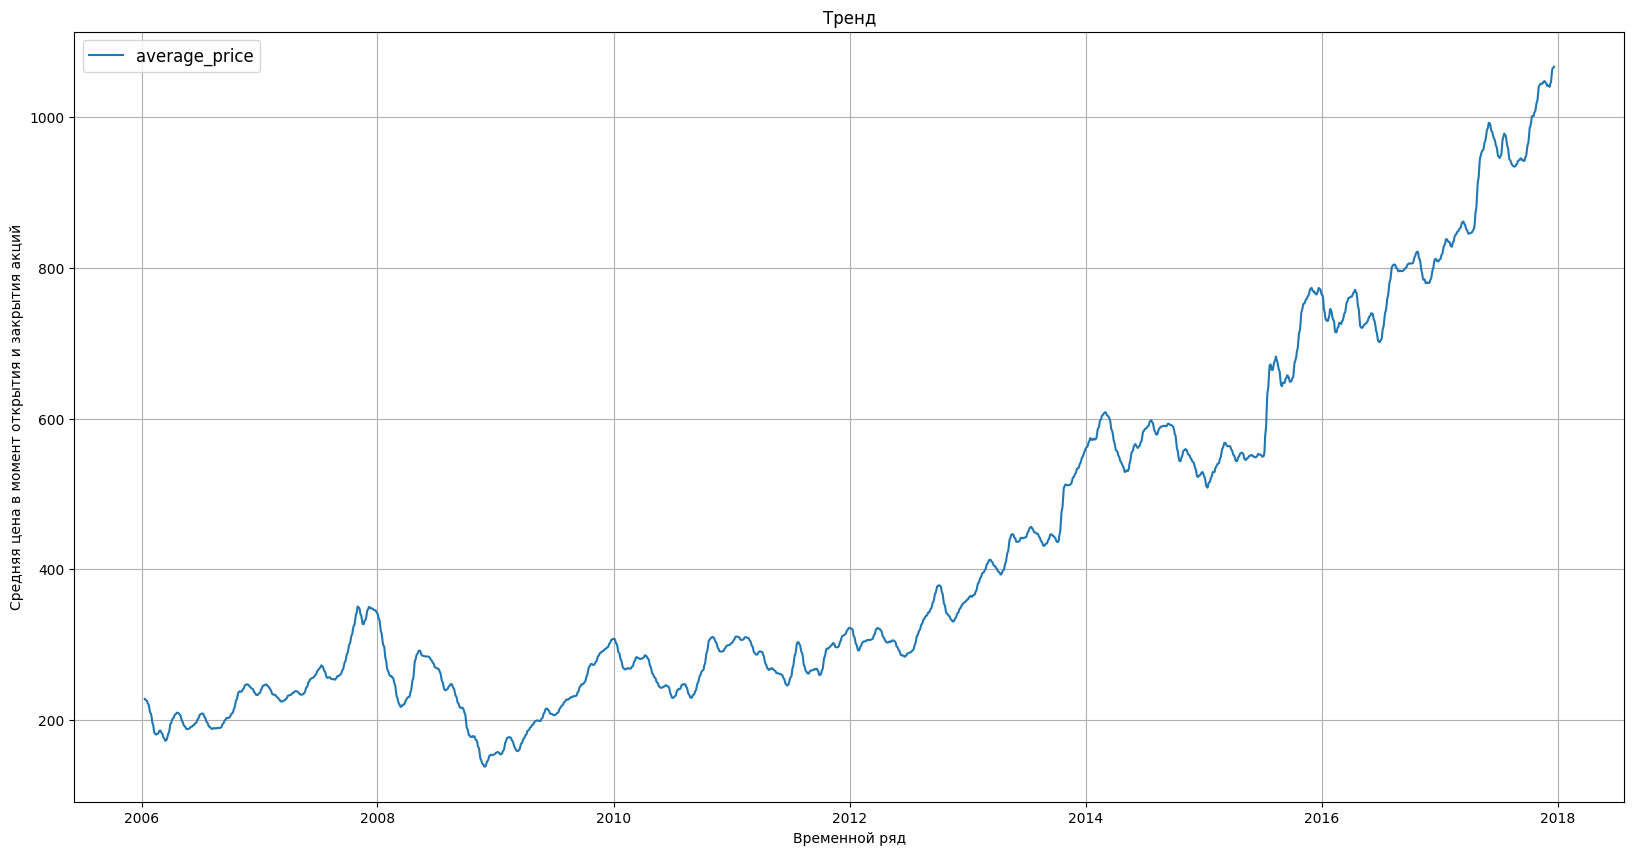

In [27]:
# Тренд
fig, ax_decomposed = plt.subplots(figsize=(20,10))

ax_decomposed.plot(decomposed.trend.index, decomposed.trend)
ax_decomposed.grid()

plt.title('Тренд')
ax_decomposed.set_xlabel('Временной ряд')
ax_decomposed.set_ylabel('Средняя цена в момент открытия и закрытия акций')
ax_decomposed.legend(df_train_temp, fontsize='larger')

plt.show()

Тренд в последнее время увеличивается

#### Сезонность

Рассмотрим сезонность в коротком промежутке, т.к. на длинном он не приносит мало полезных информаций. Рассмотрим за неделю

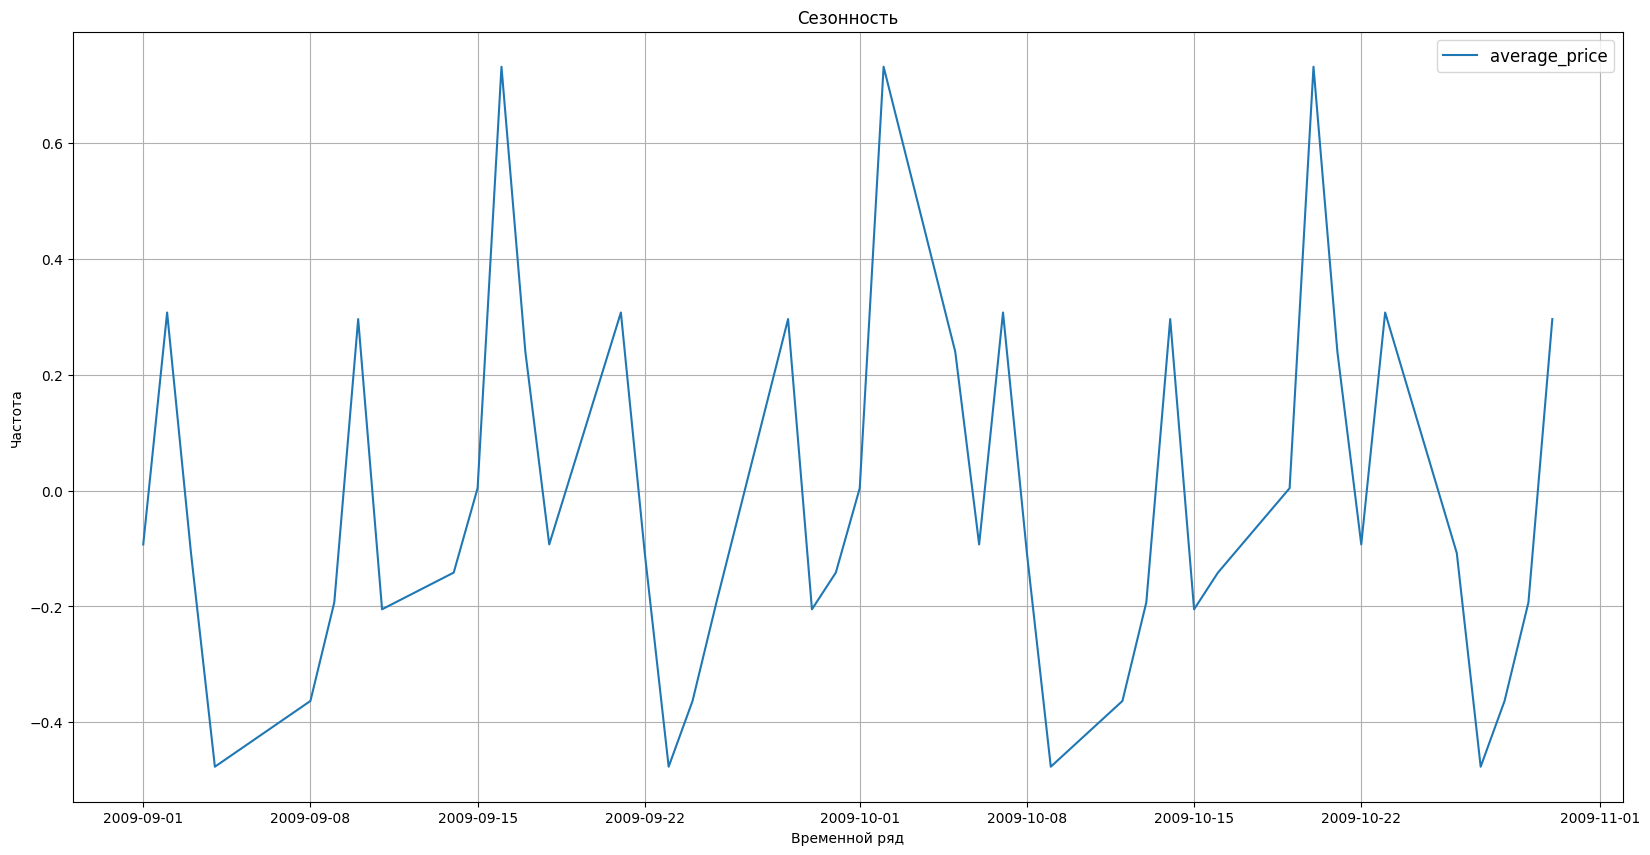

In [28]:
fig, ax_decomposed = plt.subplots(figsize=(20,10))

ax_decomposed.plot(decomposed.seasonal['2009-09-01':'2009-11-01'].index, decomposed.seasonal['2009-09-01':'2009-11-01'])
ax_decomposed.grid()

plt.title('Сезонность')
ax_decomposed.set_xlabel('Временной ряд')
ax_decomposed.set_ylabel('Частота')
ax_decomposed.legend(df_train_temp, fontsize='larger')

plt.show()

График представляет собой цикличным способом (выглядит почти как кардиограмма сердца). Можно предполагать, что этот временной ряд стационарен, однако все равно лучше убедиться математическим способом, который приведен ниже

#### Остаток декомпозиции

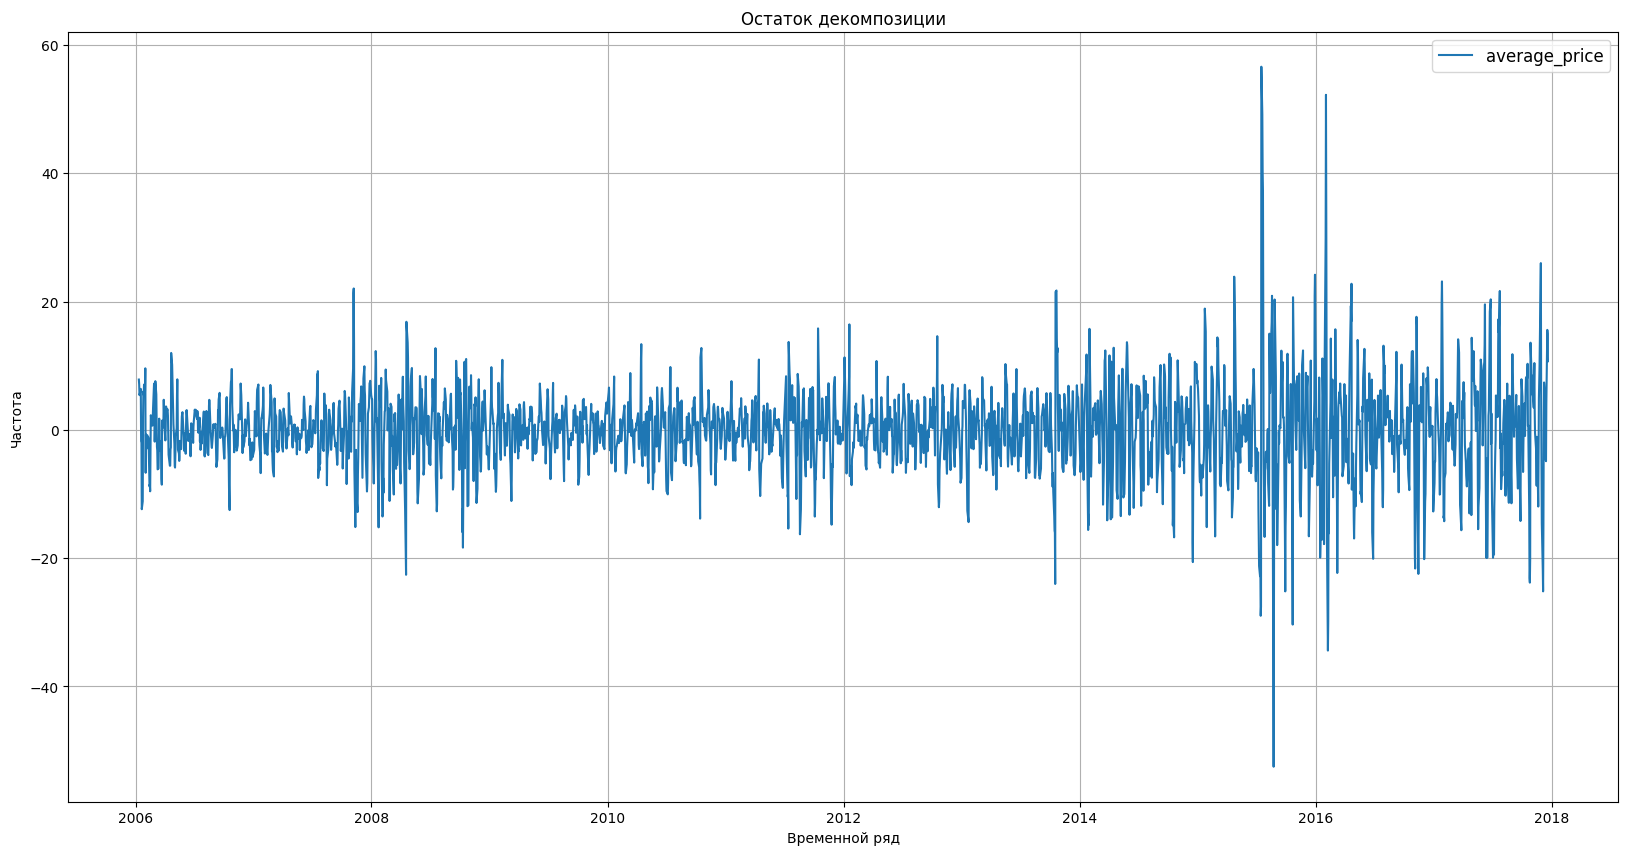

In [29]:
# Остаток декомпозиции
fig, ax_decomposed = plt.subplots(figsize=(20,10))

ax_decomposed.plot(decomposed.resid.index, decomposed.resid)
ax_decomposed.grid()

plt.title('Остаток декомпозиции')
ax_decomposed.set_xlabel('Временной ряд')
ax_decomposed.set_ylabel('Частота')
ax_decomposed.legend(df_train_temp, fontsize='larger')

plt.show()

По поводу остатка декомпозиции нужно провести исследование отдельно, причем детально, поскольку декомпозиции остатков интрепетировать сложнее, чем сезонность и тренды - в идеале, график остатков должен содержать только шум без систематических компонентов.

Если остатки систематически распределены (например, отрицательны в первой части ряда и примерно равны нуля во второй) или включают некоторую периодическую компоненту, то это свидетельствует о неадекватности модели. Анализ остатков чрезвычайно важен и необходим при анализе временных рядов. Процедура оценивания предполагает, что остатки не коррелированы и нормально распределены.

### Проверка на дисперсию математическим способом

Можно проверить дисперсию, применяя теста Андерсона-Дарлинга

In [30]:
# x - временной ряд
# dist='norm' - ожидаемое распределение (нормальное)
result = anderson(x=df_train_temp['average_price'], dist='norm')

# Статистика теста
test_statistic = result.statistic

# Критические значения для разных уровней значимости (1%, 5%, 10%)
critical_values = result.critical_values

# Если статистика теста больше критического значения для выбранного уровня значимости, то дисперсия не является постоянной
if test_statistic > critical_values[2]:
    print("Дисперсия не является постоянной")
else:
    print("Дисперсия является постоянной")

Дисперсия не является постоянной


Этот промежуток времени, т.е. с 2006 до конца, является нестанционарным, т.к. присутствует тренд, который стремится увеличиваться. А также дисперсия не является постоянной. Проверим на станционарность математическим способом.

### Проверка на стационарность математическим способом

#### Тест Дики-Фуллера

In [31]:
print('='*100)
# тест Дики-Фуллера на стационарность
print('Тест Дики-Фуллера на стационарность')
print('='*100)
result = adfuller(df_train_temp['average_price'])

print('ADF Статистка: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
print('='*100)

if(result[1] < 0.05):
    print('Принимаем альтернативную гипотезу. Временной ряд стационарен')
else:
    print('Отвергаем альтернативную гипотезу. Временной ряд не стационарен')
print('='*100)

Тест Дики-Фуллера на стационарность
ADF Статистка: 1.219026
p-value: 0.996115
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Отвергаем альтернативную гипотезу. Временной ряд не стационарен


#### Тест KPSS - Квятковский-Филлипс-Шмидт-ШинаДики-Фуллер 

In [32]:
print('='*100)
# KPSS-тест на стационарность
# KPSS - Квятковского-Филлипса-Шмидта-Шина
print('KPSS-тест на стационарность')
print('='*100)
result = kpss(df_train_temp['average_price'])
print('KPSS Статистка: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))
    
print('='*100)
#### Тест Дики-Фуллера
if(result[1] < 0.05):
    print('Принимаем альтернативную гипотезу. Временной ряд стационарен')
else:
    print('Отвергаем альтернативную гипотезу. Временной ряд не стационарен')
print('='*100)

KPSS-тест на стационарность
KPSS Статистка: 7.821837
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Принимаем альтернативную гипотезу. Временной ряд стационарен


C:\Users\nikis\AppData\Local\Temp\ipykernel_8040\2981089819.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_train_temp['average_price'])


ADF-тест не обнаруживает статистически значимого доказательства о стационарности временного ряда, в то время как KPSS-тест отвергает нулевую гипотезу о стационарности. Это противоречие может свидетельствовать о том, что ряд не является полностью стационарным, но также не является сильно нестационарным. Возможно, в ряде присутствует некоторая форма нестационарности, которая может быть устранена с помощью дополнительной обработки данных или моделирования.

### Вывод

По графику видно, что с каждым годом цена акций увеличивается, по тренду это доказано.

Также на математическом языке были доказаны следующие тесты:

 - На дисперсию
 - На стационарность
 - Тест Дики-Фуллера
 - Тест KPSS - Квятковский-Филлипс-Шмидт-ШинаДики-Фуллер

Тест на дисперсию говорит, что не является постоянной, т.е. здесь получилось, что статистика теста больше критического значения для выбранного уровня значимости

А тесты на стационарность дали разные результаты - в одном отсутствует стационарность, а в другом имеется станционарность. Исходя из этих факторов, различные результаты тестов могут быть объяснены разными свойствами и характеристиками временного ряда. Важно учитывать контекст и особенности данных при интерпретации результатов тестов на стационарность.




## Обучение и тестирование

In [33]:
# Сохраним результаты машинного обучения
results = pd.DataFrame()

# Счетчик для нумерация моеделй
count_model = 0

In [34]:
# Создадим признаки, чтобы правильно обучить модель
def make_features(data, column, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

### Деление на обучающей и тестовой выборки

У нас есть 2 датасета: обучающий и тестовый

In [35]:
# Сделаем копию, чтобы было удобно организовать несколько подборов
df_copy_train = df_train.copy()
df_copy_test = df_train.copy()

In [36]:
# Функция для создания новых признаков
make_features(df_copy_train, 'average_price', 48, 96)
make_features(df_copy_test, 'average_price', 48, 96)

In [37]:
features_train = df_copy_train.drop(['average_price'], axis=1)
target_train = df_copy_train['average_price']

features_test = df_copy_test.drop(['average_price'], axis=1)
target_test = df_copy_test['average_price']

In [38]:
# Проверим
print(features_train.shape)
print(features_test.shape)

(3019, 57)
(3019, 57)


In [39]:
# Проверим
display(features_train.head())
display(features_test.head())

,open,high,low,close,volume,hour,day,dayofweek,lag_1,lag_2,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,0,3,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,222.17,224.70,220.09,222.84,15292353,0,4,2,214.650,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,223.22,226.00,220.97,225.85,10815661,0,5,3,222.505,214.650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,228.66,235.49,226.85,233.06,17759521,0,6,4,224.535,222.505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,233.44,236.94,230.70,233.68,12795837,0,9,0,230.860,224.535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,open,high,low,close,volume,hour,day,dayofweek,lag_1,lag_2,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,0,3,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,222.17,224.70,220.09,222.84,15292353,0,4,2,214.650,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,223.22,226.00,220.97,225.85,10815661,0,5,3,222.505,214.650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,228.66,235.49,226.85,233.06,17759521,0,6,4,224.535,222.505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,233.44,236.94,230.70,233.68,12795837,0,9,0,230.860,224.535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Проверим
display(features_train.tail())
display(features_test.tail())

,open,high,low,close,volume,hour,day,dayofweek,lag_1,lag_2,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,0,22,4,1073.120,1077.240,...,994.945,988.865,987.495,995.360,1006.060,1003.295,1011.895,1009.220,1009.490,994.559115
2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,0,26,1,1069.430,1073.120,...,1032.330,994.945,988.865,987.495,995.360,1006.060,1003.295,1011.895,1009.220,995.863177
2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,0,27,2,1067.245,1069.430,...,1031.145,1032.330,994.945,988.865,987.495,995.360,1006.060,1003.295,1011.895,997.196302
2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,0,28,3,1063.400,1067.245,...,1033.020,1031.145,1032.330,994.945,988.865,987.495,995.360,1006.060,1003.295,998.593229
2017-12-29,1055.49,1058.05,1052.70,1053.40,1180340,0,29,4,1059.100,1063.400,...,1039.460,1033.020,1031.145,1032.330,994.945,988.865,987.495,995.360,1006.060,999.970312


,open,high,low,close,volume,hour,day,dayofweek,lag_1,lag_2,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,0,22,4,1073.120,1077.240,...,994.945,988.865,987.495,995.360,1006.060,1003.295,1011.895,1009.220,1009.490,994.559115
2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,0,26,1,1069.430,1073.120,...,1032.330,994.945,988.865,987.495,995.360,1006.060,1003.295,1011.895,1009.220,995.863177
2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,0,27,2,1067.245,1069.430,...,1031.145,1032.330,994.945,988.865,987.495,995.360,1006.060,1003.295,1011.895,997.196302
2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,0,28,3,1063.400,1067.245,...,1033.020,1031.145,1032.330,994.945,988.865,987.495,995.360,1006.060,1003.295,998.593229
2017-12-29,1055.49,1058.05,1052.70,1053.40,1180340,0,29,4,1059.100,1063.400,...,1039.460,1033.020,1031.145,1032.330,994.945,988.865,987.495,995.360,1006.060,999.970312


In [41]:
# Проверим на пропущенные значения
print('-'*100)
print('features_train')
display(features_train.isna().sum())
print('-'*100)
print('features_test')
display(features_test.isna().sum())
print('-'*100)

----------------------------------------------------------------------------------------------------
features_train


open             0
high             0
low              0
close            0
volume           0
hour             0
day              0
dayofweek        0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
lag_25          25
lag_26          26
lag_27          27
lag_28          28
lag_29          29
lag_30          30
lag_31          31
lag_32          32
lag_33          33
lag_34          34
lag_35          35
lag_36          36
lag_37          37
lag_38          38
lag_39          39
lag_40          40
lag_41          41
lag_42          42
lag_43          43
lag_44          44
lag_45      

----------------------------------------------------------------------------------------------------
features_test


open             0
high             0
low              0
close            0
volume           0
hour             0
day              0
dayofweek        0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
lag_25          25
lag_26          26
lag_27          27
lag_28          28
lag_29          29
lag_30          30
lag_31          31
lag_32          32
lag_33          33
lag_34          34
lag_35          35
lag_36          36
lag_37          37
lag_38          38
lag_39          39
lag_40          40
lag_41          41
lag_42          42
lag_43          43
lag_44          44
lag_45      

----------------------------------------------------------------------------------------------------


Есть пропущенных значений, заполним их значением 0

In [42]:
features_train = features_train.fillna(0)
features_test = features_test.fillna(0)

In [43]:
# Проверим на пропущенные значения
print('-'*100)
print('features_train')
display(features_train.isna().sum())
print('-'*100)
print('features_test')
display(features_test.isna().sum())
print('-'*100)

----------------------------------------------------------------------------------------------------
features_train


open            0
high            0
low             0
close           0
volume          0
hour            0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
lag_25          0
lag_26          0
lag_27          0
lag_28          0
lag_29          0
lag_30          0
lag_31          0
lag_32          0
lag_33          0
lag_34          0
lag_35          0
lag_36          0
lag_37          0
lag_38          0
lag_39          0
lag_40          0
lag_41          0
lag_42          0
lag_43          0
lag_44          0
lag_45          0
lag_46          0
lag_47          0
lag_48    

----------------------------------------------------------------------------------------------------
features_test


open            0
high            0
low             0
close           0
volume          0
hour            0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
lag_25          0
lag_26          0
lag_27          0
lag_28          0
lag_29          0
lag_30          0
lag_31          0
lag_32          0
lag_33          0
lag_34          0
lag_35          0
lag_36          0
lag_37          0
lag_38          0
lag_39          0
lag_40          0
lag_41          0
lag_42          0
lag_43          0
lag_44          0
lag_45          0
lag_46          0
lag_47          0
lag_48    

----------------------------------------------------------------------------------------------------


**Обучение моделей с применением TimeSeriesSplit**

Мы обучаем модель TimeSeriesSplit, у которой по индексу стоит временной ряд. А чтобы они не пересекались, это поможет инструмент TimeSeriesSplit. Как работает, рассмотрим ниже.

In [44]:
# Не будем создавать по-умолчанию, где n_splits=5, а установим n_splits=10
tscv = TimeSeriesSplit(10)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)


In [45]:
for i, (train_index, test_index) in enumerate(tscv.split(features_train)):
    print(f"Fold {i}:")
    print('='*100)
    print(f"  Train: index={train_index}")
    print('='*100)
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

Как и видим, что разделен на несколько промежутков времени, по 10 блоков времени

### LinearRegression

In [46]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [47]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

RMSE TRAIN: 3.822832006532797e-10
TIME TRAIN [s]: 0.022
CPU times: total: 15.6 ms
Wall time: 290 ms


**Проверка на тестовой выборки**

In [48]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE
RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 9.217950802816517e-10
Предсказание: 428.12240145743624
CPU times: total: 15.6 ms
Wall time: 7 ms


In [49]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'LinearRegression', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### DecisionTreeRegressor

In [50]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 201, 10), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [51]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

RMSE TRAIN: 40.244464632645034
TIME TRAIN [s]: 0.44
CPU times: total: 1min 16s
Wall time: 1min 18s


**Проверка на тестовой выборки**

In [52]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)

print('Предсказание:', predictions.mean())

RMSE TEST: 0.0
Предсказание: 428.12240145743624
CPU times: total: 0 ns
Wall time: 0 ns


In [53]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'DecisionTreeRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### RandomForestRegressor

In [54]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [55]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

C:\Users\nikis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nikis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nikis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nikis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", l

RMSE TRAIN: 48.84966377327471
TIME TRAIN [s]: 1.758
CPU times: total: 20.2 s
Wall time: 20.4 s


In [56]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)

print('Предсказание:', predictions.mean())

RMSE TEST: 1.369625086430254
Предсказание: 428.1303578567087
CPU times: total: 15.6 ms
Wall time: 16.1 ms


In [57]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'RandomForestRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### LightGBMRegressor

In [58]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [59]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4681
[LightGBM] [Info] Number of data points in the train set: 279, number of used features: 56
[LightGBM] [Info] Start training from score 209.691936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 56
[LightGBM] [Info] Start training from score 240.667704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13796
[LightGBM] [Info] Number of data points in the train set: 827, number of used features: 56
[LightGBM] [Info] Start trai

**Проверка на тестовой выборки**

In [60]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 3.669448040963121
Предсказание: 428.1224013715164
CPU times: total: 0 ns
Wall time: 0 ns


In [61]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'LightGBMRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### CatBoostRegressor

In [62]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [5, 10],
              'learning_rate' : [0.05, 0.1],
              'iterations' : [5, 10]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [63]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

0:	learn: 22.0095669	total: 165ms	remaining: 661ms
1:	learn: 21.0680902	total: 168ms	remaining: 252ms
2:	learn: 20.3120368	total: 171ms	remaining: 114ms
3:	learn: 19.5664884	total: 174ms	remaining: 43.4ms
4:	learn: 18.7716703	total: 177ms	remaining: 0us
0:	learn: 43.9475748	total: 3.58ms	remaining: 14.3ms
1:	learn: 42.1278706	total: 6.9ms	remaining: 10.4ms
2:	learn: 40.4409086	total: 10.2ms	remaining: 6.82ms
3:	learn: 38.8524465	total: 13.5ms	remaining: 3.38ms
4:	learn: 37.3505473	total: 16.6ms	remaining: 0us
0:	learn: 47.0793818	total: 3.27ms	remaining: 13.1ms
1:	learn: 45.0299760	total: 6.2ms	remaining: 9.29ms
2:	learn: 43.3072529	total: 9.02ms	remaining: 6.01ms
3:	learn: 41.4960764	total: 12.4ms	remaining: 3.1ms
4:	learn: 39.7061160	total: 16.2ms	remaining: 0us
0:	learn: 44.9186338	total: 4.15ms	remaining: 16.6ms
1:	learn: 42.8817721	total: 7.82ms	remaining: 11.7ms
2:	learn: 41.1869433	total: 11.1ms	remaining: 7.42ms
3:	learn: 39.4284426	total: 14.6ms	remaining: 3.66ms
4:	learn: 37.

**Проверка на тестовой выборки**

In [64]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 88.79791205086944
Предсказание: 427.93878430354386
CPU times: total: 0 ns
Wall time: 10 ms


In [65]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'CatBoostRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### XGBRegressor

In [66]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {"learning_rate": (0.05, 0.10),
              "max_depth": [5, 15],
              "min_child_weight": [1, 7],
              "gamma":[0.0, 0.2],
              "colsample_bytree":[0.3, 0.4],}

# Инициализируем модель c параметрами
model = GridSearchCV(xgb.XGBRegressor(), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [67]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

RMSE TRAIN: 42.3979935027012
TIME TRAIN [s]: 3.126
CPU times: total: 1h 20min 55s
Wall time: 7min 52s


**Проверка на тестовой выборки**

In [68]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 0.4643759627743186
Предсказание: 428.12164
CPU times: total: 266 ms
Wall time: 26 ms


In [69]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'XGBRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### Результаты

In [70]:
results = pd.DataFrame(results).T

In [71]:
# Смотрим на результаты
results

,NAME,RMSE TRAIN,RMSE TEST,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],PARAMETRS
0,LinearRegression,0.0,0.0,"[214.64999999878873, 222.50500000190266, 224.5...",0.021517,0.005,{}
1,DecisionTreeRegressor,40.244465,0.0,"[214.65, 222.505, 224.535, 230.86, 233.56, 233...",0.439981,0.003,"{'max_depth': 21, 'min_samples_leaf': 1}"
2,RandomForestRegressor,48.849664,1.369625,"[211.02959999999985, 221.74363333333315, 224.6...",1.757926,0.021,"{'bootstrap': True, 'max_depth': 15, 'max_feat..."
3,LightGBMRegressor,46.596893,3.669448,"[212.60750201912327, 225.2029045836576, 225.20...",0.03064,0.004,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti..."
4,CatBoostRegressor,110.192874,88.797912,"[273.7651383695252, 273.7651383695252, 273.765...",1.549644,0.008,"{'depth': 10, 'iterations': 10, 'learning_rate..."
5,XGBRegressor,42.397994,0.464376,"[213.17856, 223.10542, 224.70964, 231.35298, 2...",3.126414,0.024,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn..."


In [72]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.5 * (1 - (results['RMSE TEST'] / results['RMSE TEST'].max())) +
    0.3 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max())) +
    0.2 * (1 - (results['TIME PREDICTION [s]'] / results['TIME PREDICTION [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [73]:
# Смотрим на результаты
results

,NAME,RMSE TRAIN,RMSE TEST,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],PARAMETRS,RATING
0,LinearRegression,0.0,0.0,"[214.64999999878873, 222.50500000190266, 224.5...",0.021517,0.005,{},0.956269
3,LightGBMRegressor,46.596893,3.669448,"[212.60750201912327, 225.2029045836576, 225.20...",0.03064,0.004,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",0.943065
1,DecisionTreeRegressor,40.244465,0.0,"[214.65, 222.505, 224.535, 230.86, 233.56, 233...",0.439981,0.003,"{'max_depth': 21, 'min_samples_leaf': 1}",0.932781
2,RandomForestRegressor,48.849664,1.369625,"[211.02959999999985, 221.74363333333315, 224.6...",1.757926,0.021,"{'bootstrap': True, 'max_depth': 15, 'max_feat...",0.648603
5,XGBRegressor,42.397994,0.464376,"[213.17856, 223.10542, 224.70964, 231.35298, 2...",3.126414,0.024,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",0.497385
4,CatBoostRegressor,110.192874,88.797912,"[273.7651383695252, 273.7651383695252, 273.765...",1.549644,0.008,"{'depth': 10, 'iterations': 10, 'learning_rate...",0.284635


Создадим отдельный датасет, в котором будет храниться реальное значение и предсказания модели

In [74]:
info_result = pd.DataFrame(index=target_test.index)
info_result['REAL'] = target_test
for i, name_model in enumerate(results['NAME']):
    info_result[name_model] = results['PREDICTIONS'][i]
info_result.head()

,REAL,LinearRegression,LightGBMRegressor,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor,CatBoostRegressor
date,,,,,,,
2006-01-03,214.650,214.650,214.650,211.029600,212.607502,273.765138,213.178558
2006-01-04,222.505,222.505,222.505,221.743633,225.202905,273.765138,223.105423
2006-01-05,224.535,224.535,224.535,224.632500,225.202905,273.765138,224.709641
2006-01-06,230.860,230.860,230.860,229.763514,231.564346,281.937215,231.352982
2006-01-09,233.560,233.560,233.560,232.649071,233.394142,281.937215,233.538986


Сразу все данные в одном графике нежелательно уложиться, т.к. не очень информативно, поэтому разобъем на 4 блока

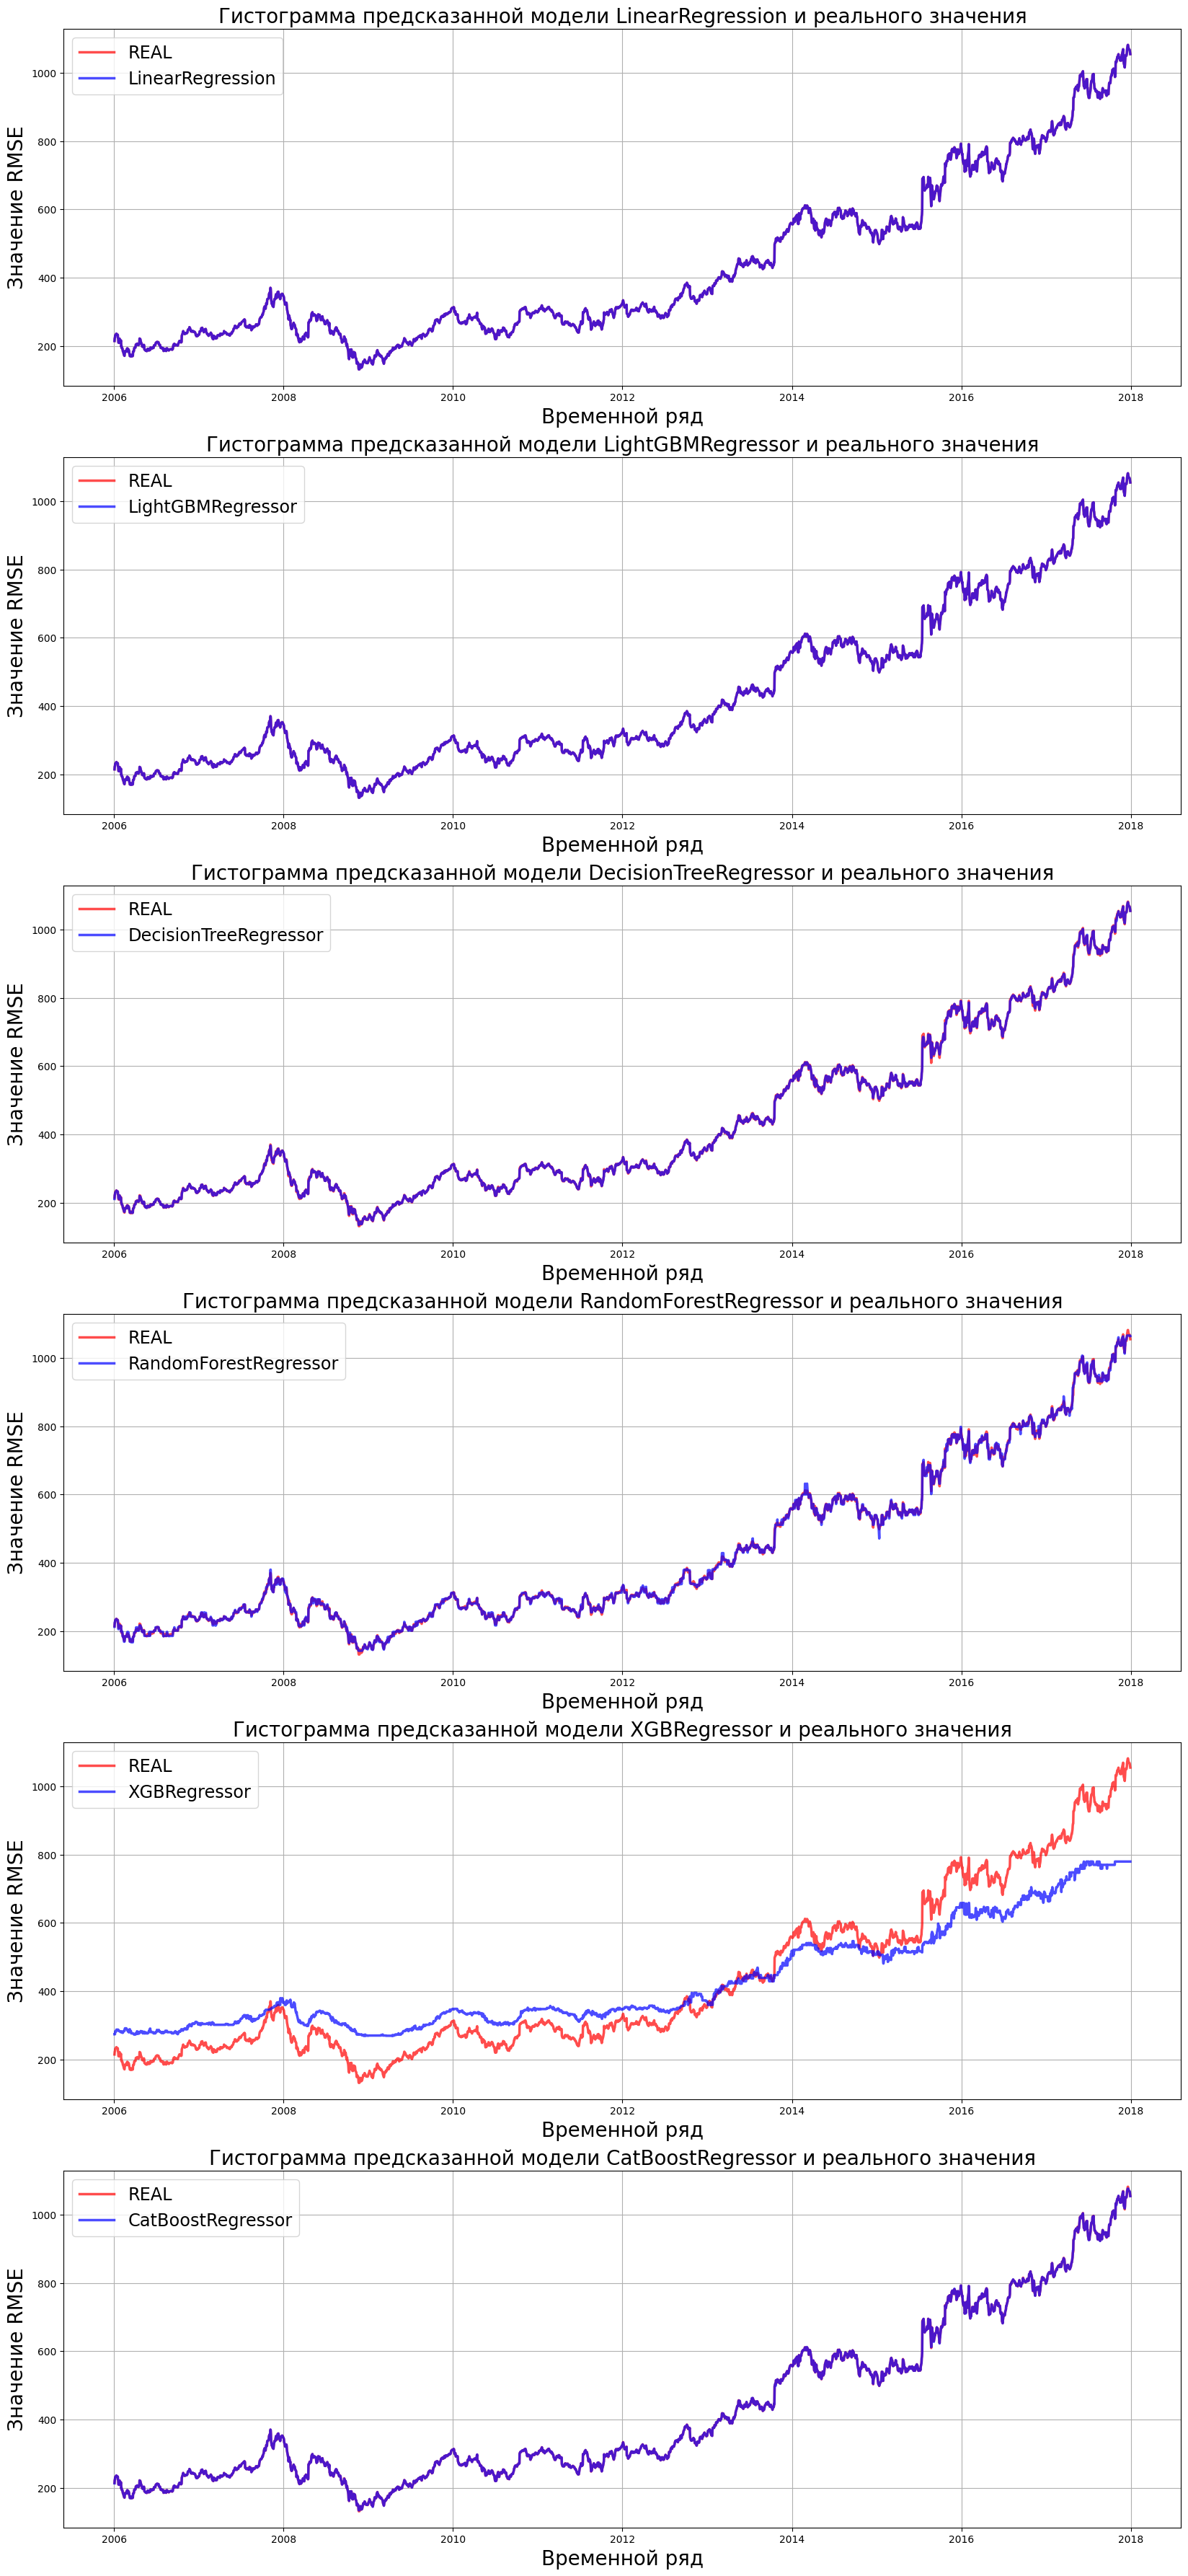

In [75]:
fig, ax = plt.subplots(6, figsize=(20, 45))

# Другие цветы тоже нежательны, они сливаются, лучше подобрать контрастные цветы
# colors = ['black', 'blue', 'orange', 'green']

for i in range(0, len(info_result.columns) - 1):
    # Посмотреть на гистограмме такое себе..., лучше на plot
    # ax[i].hist(info_result['REAL'], bins=(100), alpha=0.9, color=colors[i])
    # ax[i].hist(info_result[info_result.columns[i+1]], bins=(100), alpha=0.9, color=colors[i+1])
    ax[i].plot(info_result['REAL'], alpha=0.7, color='red', lw=2.5)
    ax[i].plot(info_result[info_result.columns[i+1]], alpha=0.7, color='blue', lw=2.5)
    ax[i].legend([info_result.columns[0], info_result.columns[i+1]], fontsize='xx-large')
    ax[i].grid()

    ax[i].set_xlabel('Временной ряд',fontsize=20)
    ax[i].set_ylabel('Значение RMSE',fontsize=20)
    ax[i].set_title(f'Гистограмма предсказанной модели {info_result.columns[i+1]} и реального значения',fontsize=20)
    
plt.show()

Предсказания модели в некотором степени отличаются от реальных значений

## Вывод


Лучшие модели - LightGBMRegressor и Linear Regression, с низкой ошибкой RMSE и быстрым временем обучения и предсказания. RandomForestRegressor и XGBRegressor также показывают хорошие результаты, но требуют больше времени на обучение. DecisionTreeRegressor имеет нулевую ошибку на обучающем наборе, что может указывать на переобучение. CatBoostRegressor показывает наихудшие результаты.